In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
from sklearn import metrics
import shap
from imblearn.over_sampling import ADASYN, SMOTE

np.random.seed(72)
import warnings

warnings.filterwarnings("ignore")

In [41]:
def create_yf_df():
    today = str(datetime.today() + timedelta(days=1)).split(" ")[0]
    data = yf.download(
        "AMZN TSLA MSFT META GOOGL AAPL SPY TQQQ SQQQ UVXY BAC NDAQ TECS qqq",
        start="2012-06-01",
        end=today,
    )
    if (data.iloc[-1, 25] / data.iloc[-2, 25]) < 0.7:
        data.iloc[-1:, 25] *= 2
        data.iloc[-1:, 23] /= 5

    stocks = [
        "AMZN",
        "TSLA",
        "MSFT",
        "META",
        "GOOGL",
        "AAPL",
        "SPY",
        "TQQQ",
        "SQQQ",
        "UVXY",
        "BAC",
        "NDAQ",
        "TECS",
        "QQQ",
    ]
    close_data = data["Close"].rename(
        columns={
            "AMZN": "AMZN_close",
            "TSLA": "TSLA_close",
            "MSFT": "MSFT_close",
            "META": "META_close",
            "GOOGL": "GOOGL_close",
            "AAPL": "AAPL_close",
            "SPY": "SPY_close",
            "UVXY": "UVXY_close",
            "TQQQ": "TQQQ_close",
            "SQQQ": "SQQQ_close",
            "BAC": "BAC_close",
            "NDAQ": "NDAQ_close",
            "TECS": "TECS_close",
            "QQQ": "QQQ_close",
        }
    )
    Volume_data = data["Volume"].rename(
        columns={
            "AMZN": "AMZN_volume",
            "TSLA": "TSLA_volume",
            "MSFT": "MSFT_volume",
            "META": "META_volume",
            "GOOGL": "GOOGL_volume",
            "AAPL": "AAPL_volume",
            "SPY": "SPY_volume",
            "UVXY": "UVXY_volume",
            "TQQQ": "TQQQ_volume",
            "SQQQ": "SQQQ_volume",
            "BAC": "BAC_volume",
            "NDAQ": "NDAQ_volume",
            "TECS": "TECS_volume",
            "QQQ": "QQQ_volume",
        }
    )

    yf_df = pd.concat([close_data, Volume_data], axis=1).reset_index()
    yf_df["AMZN"] = ""
    yf_df["TSLA"] = ""
    yf_df["MSFT"] = ""
    yf_df["META"] = ""
    yf_df["GOOGL"] = ""
    yf_df["AAPL"] = ""
    yf_df["SPY"] = ""
    yf_df["TQQQ"] = ""
    yf_df["SQQQ"] = ""
    yf_df["UVXY"] = ""
    yf_df["BAC"] = ""
    yf_df["NDAQ"] = ""
    yf_df["TECS"] = ""
    yf_df["QQQ"] = ""

    tqqq_lst = list(yf_df["TQQQ_close"])
    if tqqq_lst[-1] / tqqq_lst[-2] < 0.7:
        yf_df.loc["TQQQ_close"][-1] *= 2
        yf_df.loc["SQQQ_close"][-1] /= 5

    yf_df = yf_df[
        [
            "AMZN",
            "Date",
            "AMZN_close",
            "Date",
            "AMZN_volume",
            "TSLA",
            "Date",
            "TSLA_close",
            "Date",
            "TSLA_volume",
            "MSFT",
            "Date",
            "MSFT_close",
            "Date",
            "MSFT_volume",
            "META",
            "Date",
            "META_close",
            "Date",
            "META_volume",
            "GOOGL",
            "Date",
            "GOOGL_close",
            "Date",
            "GOOGL_volume",
            "AAPL",
            "Date",
            "AAPL_close",
            "Date",
            "AAPL_volume",
            "SPY",
            "Date",
            "SPY_close",
            #        '10 Years US Treasury Yield Curve Rates',
            "TQQQ",
            "Date",
            "TQQQ_close",
            "SQQQ",
            "Date",
            "SQQQ_close",
            "UVXY",
            "Date",
            "UVXY_close",
            "BAC",
            "Date",
            "BAC_close",
            "Date",
            "BAC_volume",
            "NDAQ",
            "Date",
            "NDAQ_close",
            "Date",
            "NDAQ_volume",
            "TECS",
            "Date",
            "TECS_close",
            "Date",
            "TECS_volume",
            "QQQ",
            "Date",
            "QQQ_close",
        ]
    ].rename(
        columns={
            "AMZN_close": "Close",
            "AMZN_volume": "Volume",
            "TSLA_close": "Close",
            "TSLA_volume": "Volume",
            "MSFT_close": "Close",
            "MSFT_volume": "Volume",
            "META_close": "Close",
            "META_volume": "Volume",
            "GOOGL_close": "Close",
            "GOOGL_volume": "Volume",
            "AAPL_close": "Close",
            "AAPL_volume": "Volume",
            "SPY_close": "Close",
            "UVXY_close": "Close",
            "TQQQ_close": "Close",
            "SQQQ_close": "Close",
            "BAC_close": "Close",
            "BAC_volume": "Volume",
            "NDAQ_close": "Close",
            "NDAQ_volume": "Volume",
            "TECS_close": "Close",
            "TECS_volume": "Volume",
            "QQQ_close": "Close",
        }
    )

    return yf_df

In [42]:
def change_date(date):
    day, month, year = date[0:10].split("/")
    return pd.to_datetime(year + month + day)

In [43]:
def change_date_for_df(dfs):
    for df in dfs:
        df["Date"] = df["Date"].apply(change_date)
        if df.shape[1] == 3:
            df["Volume"] = df["Volume"].astype(float)
        df["Close"] = df["Close"].astype(float)

## add a column of daily,weekly,monthly change (in %) for each stock.  the value is for the previous period which means if the days argument is 1 - the value will be the change from two days before until yesterday

In [44]:
def calculate_change_in_percentage(df, days, row):
    i = row.name
    if i - days > 0:
        current_price = df.iloc[i - 1, :]["Close"]
        past_price = df.iloc[i - 1 - days]["Close"]

        return (current_price / past_price - 1) * 100
    else:
        return np.nan

In [45]:
def calculate_change_in_percentage_for_dfs(dfs, dfs_names):
    for i in range(len(dfs)):
        temp = dfs[i]
        temp["change_in_percentage_for_1_day_" + dfs_names[i]] = temp.apply(
            lambda row: calculate_change_in_percentage(temp, 1, row), axis=1
        )
        temp["change_in_percentage_for_7_day_" + dfs_names[i]] = temp.apply(
            lambda row: calculate_change_in_percentage(temp, 7, row), axis=1
        )
        temp["change_in_percentage_for_30_day_" + dfs_names[i]] = temp.apply(
            lambda row: calculate_change_in_percentage(temp, 30, row), axis=1
        )

# calculating the average volume for the previous day, last 1 week, 1 month

In [46]:
def calculate_average_volume(df, days, row):

    i = row.name
    if i - days > 0:
        mean_volume = df.iloc[i - days : i, :]["Volume"].mean()

        return mean_volume
    else:
        return np.nan

In [47]:
def calculate_average_volume_for_dfs(dfs, dfs_names):
    for i in range(len(dfs)):
        if dfs_names[i] in ["qqq", "tqqq", "spy", "uvxy", "sqqq"]:
            continue
        temp = dfs[i]
        temp["Average_volume_for_1_day_" + dfs_names[i]] = temp.apply(
            lambda row: calculate_average_volume(temp, 1, row), axis=1
        )
        temp["Average_volume_for_7_day_" + dfs_names[i]] = temp.apply(
            lambda row: calculate_average_volume(temp, 7, row), axis=1
        )
        temp["Average_volume_for_30_day_" + dfs_names[i]] = temp.apply(
            lambda row: calculate_average_volume(temp, 30, row), axis=1
        )

## calculate the average close price for the last 1 week, 1 month

In [48]:
def calculate_average_close_price(df, days, row):

    i = row.name
    if i - days > 0:
        mean_price = df.iloc[i - days : i, :]["Close"].mean()

        return mean_price
    else:
        return np.nan

In [49]:
def calculate_average_close_price_for_dfs(dfs, dfs_names):
    for i in range(len(dfs)):
        temp = dfs[i]
        temp["Average_close_price_for_1_day_" + dfs_names[i]] = temp.apply(
            lambda row: calculate_average_close_price(temp, 1, row), axis=1
        )
        temp["Average_close_price_for_7_day_" + dfs_names[i]] = temp.apply(
            lambda row: calculate_average_close_price(temp, 7, row), axis=1
        )
        temp["Average_close_price_for_30_day_" + dfs_names[i]] = temp.apply(
            lambda row: calculate_average_close_price(temp, 30, row), axis=1
        )

## what was the label X days before

In [50]:
def add_label_x_days_before(df, days, row):
    i = row.name
    if i - days > 0:
        current_price = df.iloc[i - 1, :]["Close"]
        past_price = df.iloc[i - 1 - days]["Close"]

        return int(current_price > past_price)
    else:
        return np.nan

In [51]:
def add_label_x_days_before_to_qqq_df(qqq_df, sqqq=False):
    if sqqq == 0:
        qqq_df["tqqq_Positive_change_in_the_last_1_day"] = qqq_df.apply(
            lambda row: add_label_x_days_before(qqq_df, 1, row), axis=1
        )
        qqq_df["tqqq_Positive_change_in_the_last_3_day"] = qqq_df.apply(
            lambda row: add_label_x_days_before(qqq_df, 3, row), axis=1
        )

        qqq_df["tqqq_Positive_change_in_the_last_7_day"] = qqq_df.apply(
            lambda row: add_label_x_days_before(qqq_df, 7, row), axis=1
        )
        qqq_df["tqqq_Positive_change_in_the_last_30_day"] = qqq_df.apply(
            lambda row: add_label_x_days_before(qqq_df, 30, row), axis=1
        )
    elif sqqq == 1:
        qqq_df["sqqq_Positive_change_in_the_last_1_day"] = qqq_df.apply(
            lambda row: add_label_x_days_before(qqq_df, 1, row), axis=1
        )
        qqq_df["sqqq_Positive_change_in_the_last_3_day"] = qqq_df.apply(
            lambda row: add_label_x_days_before(qqq_df, 3, row), axis=1
        )

        qqq_df["sqqq_Positive_change_in_the_last_7_day"] = qqq_df.apply(
            lambda row: add_label_x_days_before(qqq_df, 7, row), axis=1
        )
        qqq_df["sqqq_Positive_change_in_the_last_30_day"] = qqq_df.apply(
            lambda row: add_label_x_days_before(qqq_df, 30, row), axis=1
        )

    elif sqqq == 2:
        qqq_df["qqq_Positive_change_in_the_last_1_day"] = qqq_df.apply(
            lambda row: add_label_x_days_before(qqq_df, 1, row), axis=1
        )
        qqq_df["qqq_Positive_change_in_the_last_3_day"] = qqq_df.apply(
            lambda row: add_label_x_days_before(qqq_df, 3, row), axis=1
        )

        qqq_df["qqq_Positive_change_in_the_last_7_day"] = qqq_df.apply(
            lambda row: add_label_x_days_before(qqq_df, 7, row), axis=1
        )
        qqq_df["qqq_Positive_change_in_the_last_30_day"] = qqq_df.apply(
            lambda row: add_label_x_days_before(qqq_df, 30, row), axis=1
        )

## Add the label - what will be the change X day to the future

In [52]:
def add_label_x_days_to_the_future(df, days, row):
    i = row.name
    if i - 1 < 0:
        return np.nan
    if i + days <= df.shape[0]:
        current_price = df.iloc[i - 1, :]["Close"]
        future_price = df.iloc[i - 1 + days]["Close"]
        return int(future_price > current_price)
    else:
        return np.nan

In [53]:
def add_label_x_days_to_the_future_to_qqq_df(qqq_df):
    qqq_df["label_1_day"] = qqq_df.apply(
        lambda row: add_label_x_days_to_the_future(qqq_df, 1, row), axis=1
    )
    qqq_df["label_7_day"] = qqq_df.apply(
        lambda row: add_label_x_days_to_the_future(qqq_df, 7, row), axis=1
    )
    qqq_df["label_30_day"] = qqq_df.apply(
        lambda row: add_label_x_days_to_the_future(qqq_df, 30, row), axis=1
    )

# Adding a function of change in % for X days

In [54]:
def calculate_change_for_x_days_to_the_future(df, days, row):
    i = row.name
    if i - 1 < 0:
        return np.nan
    if i + days <= df.shape[0]:
        current_price = df.iloc[i - 1, :]["Close"]
        future_price = df.iloc[i - 1 + days]["Close"]
        return (future_price / current_price - 1) * 100
    else:
        return np.nan

In [55]:
def add_change_for_x_days_to_the_future(qqq_df, sqqq=False):
    if sqqq == 0:
        qqq_df["tqqq_change_for_1_day"] = qqq_df.apply(
            lambda row: calculate_change_for_x_days_to_the_future(qqq_df, 1, row),
            axis=1,
        )
        qqq_df["tqqq_change_for_7_day"] = qqq_df.apply(
            lambda row: calculate_change_for_x_days_to_the_future(qqq_df, 7, row),
            axis=1,
        )
        qqq_df["tqqq_change_for_30_day"] = qqq_df.apply(
            lambda row: calculate_change_for_x_days_to_the_future(qqq_df, 30, row),
            axis=1,
        )
    elif sqqq == 1:
        qqq_df["sqqq_change_for_1_day"] = qqq_df.apply(
            lambda row: calculate_change_for_x_days_to_the_future(qqq_df, 1, row),
            axis=1,
        )
        qqq_df["sqqq_change_for_7_day"] = qqq_df.apply(
            lambda row: calculate_change_for_x_days_to_the_future(qqq_df, 7, row),
            axis=1,
        )
        qqq_df["sqqq_change_for_30_day"] = qqq_df.apply(
            lambda row: calculate_change_for_x_days_to_the_future(qqq_df, 30, row),
            axis=1,
        )
    elif sqqq == 2:
        qqq_df["qqq_change_for_1_day"] = qqq_df.apply(
            lambda row: calculate_change_for_x_days_to_the_future(qqq_df, 1, row),
            axis=1,
        )
        qqq_df["qqq_change_for_7_day"] = qqq_df.apply(
            lambda row: calculate_change_for_x_days_to_the_future(qqq_df, 7, row),
            axis=1,
        )
        qqq_df["qqq_change_for_30_day"] = qqq_df.apply(
            lambda row: calculate_change_for_x_days_to_the_future(qqq_df, 30, row),
            axis=1,
        )

## Adding a column of days in a row of a trend. Negative integer will be the number of days in a row that the stock went down and positive number will be the number of days in a row that the stock went up

In [56]:
def calculate_trend(df, row):
    trend = 0
    counter = 0
    i = row.name
    if i < 2:
        return np.nan
    for j in range(i - 1, -1, -1):
        if counter > 0:
            if df.iloc[j]["Close"] >= df.iloc[j - 1]["Close"] and trend > 0:
                trend += 1
            elif df.iloc[j]["Close"] <= df.iloc[j - 1]["Close"] and trend < 0:
                trend -= 1
            else:
                break

        else:
            if df.iloc[j]["Close"] >= df.iloc[j - 1]["Close"]:
                trend += 1
            else:
                trend -= 1
            counter += 1
    return trend

In [57]:
def add_previous_trend(trend_col, row, trend):
    i = row["row_number"]
    if str(trend) == "nan":
        return np.nan
    location = int(i - abs(trend))

    if location < 0:
        return np.nan
    return trend_col.iloc[location]

In [58]:
def add_previous_trend_for_dfs(dfs, dfs_names):
    for i in range(len(dfs)):
        temp = dfs[i]
        trend_col = temp["days_in_a_row_for_trend_" + dfs_names[i]]
        temp["row_number"] = range(len(temp))

        temp["previous_days_in_a_row_for_trend_" + dfs_names[i]] = temp.apply(
            lambda row: add_previous_trend(
                trend_col, row, row["days_in_a_row_for_trend_" + dfs_names[i]]
            ),
            axis=1,
        )

In [59]:
def calculate_trend_for_dfs(dfs, dfs_names):
    for i in range(len(dfs)):
        temp = dfs[i]
        temp["days_in_a_row_for_trend_" + dfs_names[i]] = temp.apply(
            lambda row: calculate_trend(temp, row), axis=1
        )

## Add a column that will give information about breaking highest all time

In [60]:
def get_highest_price(df):
    stock_dict = {}
    highest_price = -10
    for i, row in df.iterrows():
        new_record = 0
        date = row["Date"]  # .strftime('%Y-%m-%d')

        if i == 0:
            stock_dict[date] = np.nan
        else:
            if df.iloc[i - 1]["Close"] > highest_price:
                highest_price = df.iloc[i - 1]["Close"]
                new_record = 1
            stock_dict[date] = new_record
    return stock_dict

In [61]:
def calculate_highest_prices_dict(dfs, dfs_names):
    highest_prices_dict = {}
    for i in range(len(dfs)):
        temp = dfs[i]
        stock_dict = get_highest_price(temp)
        if temp.iloc[-1, :]["Close"] > temp.iloc[:-1, :]["Close"].max():
            new_record = 1
        else:
            new_record = 0
        stock_dict[datetime.today().strftime("%Y-%m-%d")] = new_record
        highest_prices_dict[dfs_names[i]] = stock_dict
    return highest_prices_dict

In [62]:
def add_a_break_record_column(row, records_dict, stock_name):
    date = row["Date"]  # .strftime('%Y-%m-%d')
    return records_dict[stock_name][date]

In [63]:
def add_a_break_record_column_for_dfs(dfs, highest_prices_dict, dfs_names):
    for i in range(len(dfs)):
        temp = dfs[i]
        temp["did_break_highest_all_time_" + dfs_names[i]] = temp.apply(
            lambda row: add_a_break_record_column(
                row, highest_prices_dict, dfs_names[i]
            ),
            axis=1,
        )

## Merge all the sub dfs into one big df

In [64]:
def merge_dfs(dfs):
    joined_df = dfs[0]
    for df in dfs[1:]:
        joined_df = pd.concat([joined_df, df.drop(["Date"], axis=1)], axis=1)
    return joined_df

## Normalized the numbers

In [65]:
# standard_scaler
def Normalize(Dataframe, standard_scaler=False):
    df_2 = Dataframe.select_dtypes(
        include=["float64", "int64"]
    )  # Create a data with the types that we want
    if not standard_scaler:
        standard_scaler = StandardScaler()  # We initialize our scaler
        standard_scaler.fit(df_2)  # We fit our scaler
        return (
            pd.DataFrame(
                standard_scaler.transform(df_2), index=df_2.index, columns=df_2.columns
            ),
            standard_scaler,
        )  # We transform our data using the scaler we have just fit. (original index)
    else:
        return pd.DataFrame(
            standard_scaler.transform(df_2), index=df_2.index, columns=df_2.columns
        )  # We transforn our test according the train set

In [66]:
def Normalize_minmax(Dataframe, minmax_scaler=False):
    df_2 = Dataframe.select_dtypes(
        include=["float64", "int64"]
    )  # Create a data with the types that we want
    if not minmax_scaler:  # If it's the train data (there is no scaler)
        minmax_scaler = MinMaxScaler()  # We initialize our scaler
        minmax_scaler.fit(df_2)  # We fit our scaler
        return (
            pd.DataFrame(
                minmax_scaler.transform(df_2), index=df_2.index, columns=df_2.columns
            ),
            minmax_scaler,
        )  # We transform our data using the scaler we have just fit. (original index)
    else:
        return pd.DataFrame(
            minmax_scaler.transform(df_2), index=df_2.index, columns=df_2.columns
        )  # We transforn our test according the train set

In [67]:
columns_to_merge_after_normalized = [
    #     'Date',
    "did_break_highest_all_time_amzn",
    "did_break_highest_all_time_tsla",
    "did_break_highest_all_time_msft",
    "did_break_highest_all_time_meta",
    "did_break_highest_all_time_googl",
    "did_break_highest_all_time_aapl",
    "did_break_highest_all_time_tecs",
    "did_break_highest_all_time_spy",
    # 'did_break_highest_all_time_uvxy',
    "did_break_highest_all_time_bac",
    "did_break_highest_all_time_ndaq",
    #  'tqqq_Positive_change_in_the_last_1_day',
    "tqqq_Positive_change_in_the_last_3_day",
    "tqqq_Positive_change_in_the_last_7_day",
    #     'sqqq_Positive_change_in_the_last_3_day',
    #     'sqqq_Positive_change_in_the_last_7_day',
    #  'tqqq_Positive_change_in_the_last_30_day',
    "did_break_highest_all_time_tqqq",
    #     'did_break_highest_all_time_sqqq',
    "After Covid",
    "Weekday",
    #  'label_1_day',
    #  'label_7_day',
    #  'label_30_day'
]

In [68]:
columns_to_normalize = [
    #     'change_in_percentage_for_1_day_amzn',
    "change_in_percentage_for_7_day_amzn",
    #        'change_in_percentage_for_30_day_amzn',
    #        'Average_volume_for_1_day_amzn',
    "Average_volume_for_7_day_amzn",
    #        'Average_volume_for_30_day_amzn',
    #        'Average_close_price_for_1_day_amzn',
    "Average_close_price_for_7_day_amzn",
    #        'Average_close_price_for_30_day_amzn',
    "days_in_a_row_for_trend_amzn",
    "previous_days_in_a_row_for_trend_amzn",
    #        'change_in_percentage_for_1_day_tsla',
    "change_in_percentage_for_7_day_tsla",
    #        'change_in_percentage_for_30_day_tsla',
    #        'Average_volume_for_1_day_tsla',
    "Average_volume_for_7_day_tsla",
    #        'Average_volume_for_30_day_tsla',
    #        'Average_close_price_for_1_day_tsla',
    "Average_close_price_for_7_day_tsla",
    #        'Average_close_price_for_30_day_tsla',
    "days_in_a_row_for_trend_tsla",
    "previous_days_in_a_row_for_trend_tsla",
    #        'change_in_percentage_for_1_day_msft',
    "change_in_percentage_for_7_day_msft",
    #        'change_in_percentage_for_30_day_msft',
    #        'Average_volume_for_1_day_msft',
    "Average_volume_for_7_day_msft",
    #        'Average_volume_for_30_day_msft',
    #        'Average_close_price_for_1_day_msft',
    "Average_close_price_for_7_day_msft",
    #        'Average_close_price_for_30_day_msft',
    "days_in_a_row_for_trend_msft",
    "previous_days_in_a_row_for_trend_msft",
    #        'change_in_percentage_for_1_day_meta',
    "change_in_percentage_for_7_day_meta",
    #        'change_in_percentage_for_30_day_meta',
    #        'Average_volume_for_1_day_meta',
    "Average_volume_for_7_day_meta",
    #        'Average_volume_for_30_day_meta',
    #        'Average_close_price_for_1_day_meta',
    "Average_close_price_for_7_day_meta",
    #        'Average_close_price_for_30_day_meta',
    "days_in_a_row_for_trend_meta",
    "previous_days_in_a_row_for_trend_meta",
    #         'change_in_percentage_for_1_day_googl',
    "change_in_percentage_for_7_day_googl",
    #        'change_in_percentage_for_30_day_googl',
    #        'Average_volume_for_1_day_googl',
    "Average_volume_for_7_day_googl",
    #        'Average_volume_for_30_day_googl',
    #        'Average_close_price_for_1_day_googl',
    "Average_close_price_for_7_day_googl",
    #        'Average_close_price_for_30_day_googl',
    "days_in_a_row_for_trend_googl",
    "previous_days_in_a_row_for_trend_googl",
    #         'change_in_percentage_for_1_day_aapl',
    "change_in_percentage_for_7_day_aapl",
    #        'change_in_percentage_for_30_day_aapl',
    #        'Average_volume_for_1_day_aapl',
    "Average_volume_for_7_day_aapl",
    #        'Average_volume_for_30_day_aapl',
    #        'Average_close_price_for_1_day_aapl',
    "Average_close_price_for_7_day_aapl",
    #        'Average_close_price_for_30_day_aapl',
    "days_in_a_row_for_trend_aapl",
    "previous_days_in_a_row_for_trend_aapl",
    #        'change_in_percentage_for_1_day_spy',
    "change_in_percentage_for_7_day_spy",
    #        'change_in_percentage_for_30_day_spy',
    #        'Average_close_price_for_1_day_spy',
    "Average_close_price_for_7_day_spy",
    #        'Average_close_price_for_30_day_spy',
    "days_in_a_row_for_trend_spy",
    "previous_days_in_a_row_for_trend_spy",
    #        'change_in_percentage_for_1_day_uvxy',
    "change_in_percentage_for_7_day_uvxy",
    #        'change_in_percentage_for_30_day_uvxy',
    #        'Average_close_price_for_1_day_uvxy',
    "Average_close_price_for_7_day_uvxy",
    #        'Average_close_price_for_30_day_uvxy',
    "days_in_a_row_for_trend_uvxy",
    "previous_days_in_a_row_for_trend_uvxy",
    #        'change_in_percentage_for_1_day_tqqq',
    "change_in_percentage_for_7_day_tqqq",
    #        'change_in_percentage_for_30_day_tqqq',
    #        'Average_close_price_for_1_day_tqqq',
    "Average_close_price_for_7_day_tqqq",
    #        'Average_close_price_for_30_day_tqqq',
    "days_in_a_row_for_trend_tqqq",
    "previous_days_in_a_row_for_trend_tqqq",
    #     '10 Years US Treasury Yield Curve Rates',
    #        'change_in_percentage_for_1_day_sqqq',
    #        'change_in_percentage_for_7_day_sqqq',
    #        'change_in_percentage_for_30_day_sqqq',
    #        'Average_close_price_for_1_day_sqqq',
    #        'Average_close_price_for_7_day_sqqq',
    #        'Average_close_price_for_30_day_sqqq',
    #         'days_in_a_row_for_trend_sqqq',
    #     'previous_days_in_a_row_for_trend_sqqq',
    #        'change_in_percentage_for_1_day_bac',
    "change_in_percentage_for_7_day_bac",
    #        'change_in_percentage_for_30_day_bac',
    #        'Average_volume_for_1_day_bac',
    "Average_volume_for_7_day_bac",
    #        'Average_volume_for_30_day_bac',
    #        'Average_close_price_for_1_day_bac',
    "Average_close_price_for_7_day_bac",
    #        'Average_close_price_for_30_day_bac',
    "days_in_a_row_for_trend_bac",
    "previous_days_in_a_row_for_trend_bac",
    #        'change_in_percentage_for_1_day_ndaq',
    "change_in_percentage_for_7_day_ndaq",
    #        'change_in_percentage_for_30_day_ndaq',
    #        'Average_volume_for_1_day_ndaq',
    "Average_volume_for_7_day_ndaq",
    #        'Average_volume_for_30_day_ndaq',
    #        'Average_close_price_for_1_day_ndaq',
    "Average_close_price_for_7_day_ndaq",
    #        'Average_close_price_for_30_day_ndaq',
    "days_in_a_row_for_trend_ndaq",
    "previous_days_in_a_row_for_trend_ndaq",
    #        'change_in_percentage_for_1_day_tecs',
    "change_in_percentage_for_7_day_tecs",
    #        'change_in_percentage_for_30_day_tecs',
    #        'Average_volume_for_1_day_tecs',
    "Average_volume_for_7_day_tecs",
    #        'Average_volume_for_30_day_tecs',
    #        'Average_close_price_for_1_day_tecs',
    "Average_close_price_for_7_day_tecs",
    #        'Average_close_price_for_30_day_tecs',
    "days_in_a_row_for_trend_tecs",
    "previous_days_in_a_row_for_trend_tecs",
]

## Adding a column of "after covid"

In [69]:
def after_covid(date):
    return int(date > pd.to_datetime("2019-12-01"))

In [70]:
columns_for_x = [
    #     'Date',
    "did_break_highest_all_time_amzn",
    "did_break_highest_all_time_tsla",
    "did_break_highest_all_time_msft",
    "did_break_highest_all_time_meta",
    "did_break_highest_all_time_googl",
    "did_break_highest_all_time_aapl",
    "did_break_highest_all_time_bac",
    "did_break_highest_all_time_ndaq",
    "did_break_highest_all_time_tecs",
    #     'tqqq_Positive_change_in_the_last_1_day',
    "tqqq_Positive_change_in_the_last_3_day",
    "tqqq_Positive_change_in_the_last_7_day",
    #     'sqqq_Positive_change_in_the_last_3_day',
    #     'sqqq_Positive_change_in_the_last_7_day',
    #     'tqqq_Positive_change_in_the_last_30_day',
    "did_break_highest_all_time_tqqq",
    #     'did_break_highest_all_time_sqqq',
    "did_break_highest_all_time_spy",
    #     'did_break_highest_all_time_uvxy',
    #     'change_in_percentage_for_1_day_amzn',
    "change_in_percentage_for_7_day_amzn",
    #     'change_in_percentage_for_30_day_amzn',
    #     'Average_volume_for_1_day_amzn',
    "Average_volume_for_7_day_amzn",
    #     'Average_volume_for_30_day_amzn',
    #     'Average_close_price_for_1_day_amzn',
    "Average_close_price_for_7_day_amzn",
    #     'Average_close_price_for_30_day_amzn',
    "days_in_a_row_for_trend_amzn",
    "previous_days_in_a_row_for_trend_amzn",
    #     'change_in_percentage_for_1_day_tsla',
    "change_in_percentage_for_7_day_tsla",
    #     'change_in_percentage_for_30_day_tsla',
    #     'Average_volume_for_1_day_tsla',
    "Average_volume_for_7_day_tsla",
    #     'Average_volume_for_30_day_tsla',
    #     'Average_close_price_for_1_day_tsla',
    "Average_close_price_for_7_day_tsla",
    #     'Average_close_price_for_30_day_tsla',
    "days_in_a_row_for_trend_tsla",
    "previous_days_in_a_row_for_trend_tsla",
    #     'change_in_percentage_for_1_day_msft',
    "change_in_percentage_for_7_day_msft",
    #     'change_in_percentage_for_30_day_msft',
    #     'Average_volume_for_1_day_msft',
    "Average_volume_for_7_day_msft",
    #     'Average_volume_for_30_day_msft',
    #     'Average_close_price_for_1_day_msft',
    "Average_close_price_for_7_day_msft",
    #     'Average_close_price_for_30_day_msft',
    "days_in_a_row_for_trend_msft",
    "previous_days_in_a_row_for_trend_msft",
    #     'change_in_percentage_for_1_day_meta',
    "change_in_percentage_for_7_day_meta",
    #     'change_in_percentage_for_30_day_meta',
    #     'Average_volume_for_1_day_meta',
    "Average_volume_for_7_day_meta",
    #     'Average_volume_for_30_day_meta',
    #     'Average_close_price_for_1_day_meta',
    "Average_close_price_for_7_day_meta",
    #     'Average_close_price_for_30_day_meta',
    "days_in_a_row_for_trend_meta",
    "previous_days_in_a_row_for_trend_meta",
    #     'change_in_percentage_for_1_day_googl',
    "change_in_percentage_for_7_day_googl",
    #     'change_in_percentage_for_30_day_googl',
    #     'Average_volume_for_1_day_googl',
    "Average_volume_for_7_day_googl",
    #     'Average_volume_for_30_day_googl',
    #     'Average_close_price_for_1_day_googl',
    "Average_close_price_for_7_day_googl",
    #     'Average_close_price_for_30_day_googl',
    "days_in_a_row_for_trend_googl",
    "previous_days_in_a_row_for_trend_googl",
    #     'change_in_percentage_for_1_day_aapl',
    "change_in_percentage_for_7_day_aapl",
    #     'change_in_percentage_for_30_day_aapl',
    #     'Average_volume_for_1_day_aapl',
    "Average_volume_for_7_day_aapl",
    #     'Average_volume_for_30_day_aapl',
    #     'Average_close_price_for_1_day_aapl',
    "Average_close_price_for_7_day_aapl",
    #     'Average_close_price_for_30_day_aapl',
    "days_in_a_row_for_trend_aapl",
    "previous_days_in_a_row_for_trend_aapl",
    #     'change_in_percentage_for_1_day_spy',
    "change_in_percentage_for_7_day_spy",
    #     'change_in_percentage_for_30_day_spy',
    #     'Average_close_price_for_1_day_spy',
    "Average_close_price_for_7_day_spy",
    #     'Average_close_price_for_30_day_spy',
    "days_in_a_row_for_trend_spy",
    "previous_days_in_a_row_for_trend_spy",
    #     'change_in_percentage_for_1_day_uvxy',
    "change_in_percentage_for_7_day_uvxy",
    #     'change_in_percentage_for_30_day_uvxy',
    #     'Average_close_price_for_1_day_uvxy',
    "Average_close_price_for_7_day_uvxy",
    #     'Average_close_price_for_30_day_uvxy',
    "days_in_a_row_for_trend_uvxy",
    "previous_days_in_a_row_for_trend_uvxy",
    #     'change_in_percentage_for_1_day_tqqq',
    "change_in_percentage_for_7_day_tqqq",
    #     'change_in_percentage_for_30_day_tqqq',
    #     'Average_close_price_for_1_day_tqqq',
    "Average_close_price_for_7_day_tqqq",
    #     'Average_close_price_for_30_day_tqqq',
    "days_in_a_row_for_trend_tqqq",
    "previous_days_in_a_row_for_trend_tqqq",
    #     'change_in_percentage_for_1_day_sqqq',
    #     'change_in_percentage_for_7_day_sqqq',
    #     'change_in_percentage_for_30_day_sqqq',
    #     'Average_close_price_for_1_day_sqqq',
    #     'Average_close_price_for_7_day_sqqq',
    #     'Average_close_price_for_30_day_sqqq',
    #     'days_in_a_row_for_trend_sqqq',
    #     'previous_days_in_a_row_for_trend_sqqq',
    #     'change_in_percentage_for_1_day_bac',
    "change_in_percentage_for_7_day_bac",
    #     'change_in_percentage_for_30_day_bac',
    #     'Average_volume_for_1_day_bac',
    "Average_volume_for_7_day_bac",
    #     'Average_volume_for_30_day_bac',
    #     'Average_close_price_for_1_day_bac',
    "Average_close_price_for_7_day_bac",
    #     'Average_close_price_for_30_day_bac',
    "days_in_a_row_for_trend_bac",
    "previous_days_in_a_row_for_trend_bac",
    #     'change_in_percentage_for_1_day_ndaq',
    "change_in_percentage_for_7_day_ndaq",
    #     'change_in_percentage_for_30_day_ndaq',
    #     'Average_volume_for_1_day_ndaq',
    "Average_volume_for_7_day_ndaq",
    #     'Average_volume_for_30_day_ndaq',
    #     'Average_close_price_for_1_day_ndaq',
    "Average_close_price_for_7_day_ndaq",
    #     'Average_close_price_for_30_day_ndaq',
    "days_in_a_row_for_trend_ndaq",
    "previous_days_in_a_row_for_trend_ndaq",
    #     'change_in_percentage_for_1_day_tecs',
    "change_in_percentage_for_7_day_tecs",
    #     'change_in_percentage_for_30_day_tecs',
    #     'Average_volume_for_1_day_tecs',
    "Average_volume_for_7_day_tecs",
    #     'Average_volume_for_30_day_tecs',
    #     'Average_close_price_for_1_day_tecs',
    "Average_close_price_for_7_day_tecs",
    #     'Average_close_price_for_30_day_tecs',
    "days_in_a_row_for_trend_tecs",
    "previous_days_in_a_row_for_trend_tecs",
    "After Covid",
    "Weekday",
    #     '10 Years US Treasury Yield Curve Rates'
]
# x=data_after_normalize[columns_for_x]

column_for_y = [
    "label_1_day",
    #     'label_7_day',
    #     'label_30_day'
]
# y = data_after_normalize[columns_for_y]

positive_column_for_real_money_check = "tqqq_change_for_1_day"
negative_column_for_real_money_check = "sqqq_change_for_1_day"
positive_column_for_real_money_check_qqq = "qqq_change_for_1_day"

## PCA 
At first, I decrease the dimentions with PCA and check my model. In the future, I will make feature selection finction and run the model with my best features. Then I will be able to analize the data with lime and shap

In [71]:
def pca_cols(relevant_data, threshold, pca=False):
    if not pca:
        pca_num = PCA(n_components=relevant_data.shape[1])  # Initialize PCA object
        pca_num = pca_num.fit(relevant_data)  # Fit the model with the data
        pca_exp = (
            pca_num.explained_variance_ratio_
        )  # Percentage of variance explained by each of the selected components

        print(
            "\n\nFor visualization this is the cumulative explained variance plot for each numeric column"
        )
        plt.plot(
            np.cumsum(pca_exp), color="blueviolet"
        )  # Plot for visualozation- the number of components vs cumulative explained variance
        plt.xlabel("number of components")  # Add title for x-axis
        plt.ylabel("cumulative explained variance")  # Add title for y-axis
        plt.grid()  # Add grid for the plot
        plt.show()  # show the plot

        print(
            "\nNow we apply the pca that will explain at least ", threshold * 100, " %"
        )
        pca = PCA(threshold)  # Initialize PCA object that will explain the threshold
        pca = pca.fit(relevant_data)  # Fit the model with the data
        pca_explain = (
            pca.explained_variance_ratio_
        )  # Percentage of variance explained by each of the selected components
        print(
            "\nThe cumulative explained variance for this pca action is:",
            sum(pca_explain),
        )
        data_after_pca = pd.DataFrame(
            pca.transform(relevant_data), index=relevant_data.index
        )  # Apply the PCA on the train data
        return data_after_pca, pca
    else:
        data_after_pca = pd.DataFrame(
            pca.transform(relevant_data), index=relevant_data.index
        )  # Apply the PCA on the test data
        return data_after_pca

# Over sampling

In [72]:
def make_adasyn(x, y):
    ad = ADASYN(random_state=42)  # create adasyn object
    X_res, y_res = ad.fit_resample(x, y)  # fit&resample on adasyn with the data
    return X_res, y_res

In [73]:
def make_smote(x, y):
    sm = SMOTE(sampling_strategy=1, random_state=42)  # create adasyn object
    X_res, y_res = sm.fit_resample(x, y)  # fit&resample on adasyn with the data
    return X_res, y_res

In [74]:
new_columns_for_x_temp = columns_for_x.copy()
remove_lst = [
    "did_break_highest_all_time_amzn",
    "did_break_highest_all_time_tsla",
    "did_break_highest_all_time_msft",
    "did_break_highest_all_time_meta",
    "did_break_highest_all_time_googl",
    "did_break_highest_all_time_aapl",
    "did_break_highest_all_time_bac",
    "did_break_highest_all_time_ndaq",
    "did_break_highest_all_time_tecs",
    "tqqq_Positive_change_in_the_last_7_day",
    "tqqq_Positive_change_in_the_last_3_day",
    #          'sqqq_Positive_change_in_the_last_7_day',
    #     'sqqq_Positive_change_in_the_last_3_day',
    "did_break_highest_all_time_tqqq",
    "did_break_highest_all_time_spy",
    #  'did_break_highest_all_time_uvxy',
    "change_in_percentage_for_7_day_amzn",
    "Average_volume_for_7_day_amzn",
    "Average_close_price_for_7_day_amzn",
    "days_in_a_row_for_trend_amzn",
    "previous_days_in_a_row_for_trend_amzn",
    "change_in_percentage_for_7_day_tsla",
    "Average_volume_for_7_day_tsla",
    "Average_close_price_for_7_day_tsla",
    "days_in_a_row_for_trend_tsla",
    "previous_days_in_a_row_for_trend_tsla",
    #  'change_in_percentage_for_7_day_msft',
    "Average_volume_for_7_day_msft",
    "Average_close_price_for_7_day_msft",
    #  'days_in_a_row_for_trend_msft',
    "previous_days_in_a_row_for_trend_msft",
    "change_in_percentage_for_7_day_meta",
    "Average_volume_for_7_day_meta",
    "Average_close_price_for_7_day_meta",
    #  'days_in_a_row_for_trend_meta',
    "previous_days_in_a_row_for_trend_meta",
    "change_in_percentage_for_7_day_googl",
    "Average_volume_for_7_day_googl",
    "Average_close_price_for_7_day_googl",
    "days_in_a_row_for_trend_googl",
    "previous_days_in_a_row_for_trend_googl",
    "change_in_percentage_for_7_day_aapl",
    "Average_volume_for_7_day_aapl",
    "Average_close_price_for_7_day_aapl",
    "days_in_a_row_for_trend_aapl",
    "previous_days_in_a_row_for_trend_aapl",
    "change_in_percentage_for_7_day_spy",
    "Average_close_price_for_7_day_spy",
    "days_in_a_row_for_trend_spy",
    "previous_days_in_a_row_for_trend_spy",
    "change_in_percentage_for_7_day_uvxy",
    "Average_close_price_for_7_day_uvxy",
    "days_in_a_row_for_trend_uvxy",
    "previous_days_in_a_row_for_trend_uvxy",
    #  'change_in_percentage_for_7_day_tqqq',
    "Average_close_price_for_7_day_tqqq",
    #  'days_in_a_row_for_trend_tqqq',
    #     'previous_days_in_a_row_for_trend_tqqq',
    #     '10 Years US Treasury Yield Curve Rates',
    "change_in_percentage_for_7_day_bac",
    "Average_volume_for_7_day_bac",
    "Average_close_price_for_7_day_bac",
    "days_in_a_row_for_trend_bac",
    "previous_days_in_a_row_for_trend_bac",
    "change_in_percentage_for_7_day_ndaq",
    "Average_volume_for_7_day_ndaq",
    "Average_close_price_for_7_day_ndaq",
    "days_in_a_row_for_trend_ndaq",
    #     'previous_days_in_a_row_for_trend_ndaq',
    #  'change_in_percentage_for_7_day_tecs',
    "Average_volume_for_7_day_tecs",
    "Average_close_price_for_7_day_tecs",
    "days_in_a_row_for_trend_tecs",
    "previous_days_in_a_row_for_trend_tecs",
    "After Covid",
    # 'Weekday',
]
for i in remove_lst:
    new_columns_for_x_temp.remove(i)
# new_final_train_data_temp = final_train_data[new_columns_for_x_temp]
# new_test_data_temp = test_data[new_columns_for_x_temp]

In [79]:
def preproccesing_data(yf_df=False, history=False):
    if not yf_df:
        print("not yf")
        result = load_data()
        info = result[1:]
        columns = result[0]
        df = pd.DataFrame(info, columns=columns)
        tqqq_df = df.iloc[:, [35, 36]]
        sqqq_df = df.iloc[:, [38, 39]]
        uvxy_df = df.iloc[:, [41, 42]]

    else:
        print("yf")
        df = create_yf_df()
        tqqq_df = df.iloc[:, [34, 35]]
        sqqq_df = df.iloc[:, [37, 38]]
        if int(df[df.iloc[:, 1] == "2020-02-14"].iloc[:, 38]) < 50:
            changing_part_sqqq = np.array(df.iloc[:1940, 38]) * 5
            remaining_part_sqqq = np.array(df.iloc[1940:, 38])
            new_sqqq_column = list(
                np.concatenate((changing_part_sqqq, remaining_part_sqqq))
            )
            changing_part_tqqq = np.array(df.iloc[:1940, 35]) * 0.5
            remaining_part_tqqq = np.array(df.iloc[1940:, 35])
            new_tqqq_column = list(
                np.concatenate((changing_part_tqqq, remaining_part_tqqq))
            )
            df["sqqq_close"] = new_sqqq_column
            df["tqqq_close"] = new_tqqq_column
            tqqq_df["Close"] = df["tqqq_close"]
            sqqq_df["Close"] = df["sqqq_close"]
        uvxy_df = df.iloc[:, [40, 41]]

    # Creating a DataFrame for each stock:
    amzn_df = df.iloc[:, [1, 2, 4]]
    tsla_df = df.iloc[:, [6, 7, 9]]
    msft_df = df.iloc[:, [11, 12, 14]]
    meta_df = df.iloc[:, [16, 17, 19]]
    googl_df = df.iloc[:, [21, 22, 24]]
    aapl_df = df.iloc[:, [26, 27, 29]]
    bac_df = df.iloc[:, [43, 44, 46]]
    ndaq_df = df.iloc[:, [48, 49, 51]]
    tecs_df = df.iloc[:, [53, 54, 56]]
    qqq_df = df.iloc[:, [58, 59]]

    spy_df = df.iloc[:, [31, 32]]
    #     US_treasury_rate_10_years = df.iloc[:,28]
    dfs = [
        amzn_df,
        tsla_df,
        msft_df,
        meta_df,
        googl_df,
        aapl_df,
        spy_df,
        tqqq_df,
        sqqq_df,
        uvxy_df,
        bac_df,
        ndaq_df,
        tecs_df,
        qqq_df,
    ]
    dfs_names = [
        "amzn",
        "tsla",
        "msft",
        "meta",
        "googl",
        "aapl",
        "spy",
        "tqqq",
        "sqqq",
        "uvxy",
        "bac",
        "ndaq",
        "tecs",
        "qqq",
    ]

    if not yf_df:
        change_date_for_df(dfs)
    calculate_change_in_percentage_for_dfs(dfs, dfs_names)
    calculate_average_volume_for_dfs(dfs, dfs_names)
    calculate_average_close_price_for_dfs(dfs, dfs_names)

    add_label_x_days_before_to_qqq_df(tqqq_df)
    add_label_x_days_to_the_future_to_qqq_df(tqqq_df)
    add_change_for_x_days_to_the_future(tqqq_df)

    add_label_x_days_before_to_qqq_df(sqqq_df, 1)
    add_change_for_x_days_to_the_future(sqqq_df, 1)

    add_label_x_days_before_to_qqq_df(qqq_df, 2)
    add_change_for_x_days_to_the_future(qqq_df, 2)

    calculate_trend_for_dfs(dfs, dfs_names)
    add_previous_trend_for_dfs(dfs, dfs_names)
    highest_prices_dict = calculate_highest_prices_dict(dfs, dfs_names)
    add_a_break_record_column_for_dfs(dfs, highest_prices_dict, dfs_names)
    merged_dfs = merge_dfs(dfs)
    merged_dfs = merged_dfs.drop(["Volume", "Close"], axis=1)
    merged_dfs["After Covid"] = merged_dfs["Date"].apply(after_covid)
    #     merged_dfs = pd.concat([merged_dfs,US_treasury_rate_10_years],axis=1)
    merged_dfs["Weekday"] = merged_dfs["Date"].dt.dayofweek

    merged_dfs = merged_dfs.set_index("Date").sort_index()
    #     merged_dfs['10 Years US Treasury Yield Curve Rates'] = merged_dfs['10 Years US Treasury Yield Curve Rates'].astype(float)
    if history:
        return merged_dfs.iloc[10:]
    else:
        return merged_dfs.iloc[10:-10]

In [81]:
def split_data_into_train_test(
    all_data,
    features,
    label,
    column_for_real_money_check,
    column_for_real_money_check_2,
    positive_column_for_real_money_check_qqq,
    train_data_from=-1000,
    train_data_until=-60,
):
    x = all_data[
        features
        + [column_for_real_money_check]
        + [column_for_real_money_check_2]
        + [positive_column_for_real_money_check_qqq]
    ]
    y = all_data[label]
    x = x.sort_index()
    y = y.sort_index()
    if train_data_until == -1:

        x_test = x.iloc[train_data_until:, :]
        y_test = y.iloc[train_data_until:, :]
        x_train = x.iloc[train_data_from : train_data_until - 40, :]
        y_train = y.iloc[train_data_from : train_data_until - 40, :]
        x_train = x_train.sort_index()
        y_train = y_train.sort_index()
    else:

        x_test = x.iloc[train_data_until : train_data_until + 1, :]

        y_test = y.iloc[train_data_until : train_data_until + 1, :]
        x_train = x.iloc[train_data_from : train_data_until - 40, :]
        y_train = y.iloc[train_data_from : train_data_until - 40, :]
        x_train = x_train.sort_index()
        y_train = y_train.sort_index()
    return x_train, x_test, y_train, y_test

In [82]:
def PreProccesing(
    columns_to_merge_after_normalized,
    columns_to_normalize,
    columns_for_x,
    column_for_y,
    column_for_real_money_check,
    column_for_real_money_check_2,
    positive_column_for_real_money_check_qqq,
    new_columns_for_x_temp,
    pca=False,
    adasyn=False,
    yf_df=False,
):
    merged_dfs = preproccesing_data(yf_df)
    x_train_temp, x_test_temp, y_train, y_test = split_data_into_train_test(
        merged_dfs,
        columns_for_x,
        column_for_y,
        column_for_real_money_check,
        column_for_real_money_check_2,
        positive_column_for_real_money_check_qqq,
    )

    x_train = x_train_temp[columns_for_x]
    x_test = x_test_temp[columns_for_x]

    y_in_percentage_train = x_train_temp[
        column_for_real_money_check
    ]  # .reset_index(drop=True,inplace=True)
    y_in_percentage_test = x_test_temp[
        column_for_real_money_check
    ]  # .reset_index(drop=True,inplace=True)

    negative_y_in_percentage_train = x_train_temp[
        column_for_real_money_check_2
    ]  # .reset_index(drop=True,inplace=True)
    negative_y_in_percentage_test = x_test_temp[
        column_for_real_money_check_2
    ]  # .reset_index(drop=True,inplace=True)

    qqq_y_in_percentage_train = x_train_temp[positive_column_for_real_money_check_qqq]
    qqq_y_in_percentage_test = x_test_temp[positive_column_for_real_money_check_qqq]

    normal_data_train, standard_scaler = Normalize_minmax(x_train[columns_to_normalize])
    data_after_normalize_train = pd.concat(
        [x_train[columns_to_merge_after_normalized], normal_data_train], axis=1
    )
    x_train_after_normalize = data_after_normalize_train[columns_for_x]
    normal_data_test = Normalize_minmax(x_test[columns_to_normalize], standard_scaler)

    data_after_normalize_test = pd.concat(
        [x_test[columns_to_merge_after_normalized], normal_data_test], axis=1
    )

    x_test_after_normalize = data_after_normalize_test[columns_for_x]
    if adasyn:
        x_train_after_normalize, y_train = make_smote(x_train_after_normalize, y_train)

    x_train_after_normalize = x_train_after_normalize[new_columns_for_x_temp]
    x_test_after_normalize = x_test_after_normalize[new_columns_for_x_temp]
    if pca:

        data_after_pca_train, pca = pca_cols(x_train_after_normalize, 0.75)
        data_after_pca_test = pca_cols(x_test_after_normalize, 0.75, pca)
        return (
            data_after_pca_train,
            data_after_pca_test,
            y_train,
            y_test,
            y_in_percentage_train,
            y_in_percentage_test,
            qqq_y_in_percentage_train,
            qqq_y_in_percentage_test,
            standard_scaler,
            pca,
        )
    return (
        x_train_after_normalize,
        x_test_after_normalize,
        y_train,
        y_test,
        y_in_percentage_train,
        y_in_percentage_test,
        negative_y_in_percentage_train,
        negative_y_in_percentage_test,
        qqq_y_in_percentage_train,
        qqq_y_in_percentage_test,
        standard_scaler,
    )

# Create test-train sets that the train set has Y rows. The sets will be for the last X months. no future data!!!

In [83]:
df_temp = preproccesing_data(1, 1)

yf


[*********************100%%**********************]  14 of 14 completed


In [85]:
train_data_from_lst = list(range(-len(df_temp), -400))
train_data_until_lst = [i + 400 for i in train_data_from_lst]

In [86]:
def create_sets(
    merged_df,
    columns_to_merge_after_normalized,
    columns_to_normalize,
    columns_for_x,
    column_for_y,
    column_for_real_money_check,
    column_for_real_money_check_2,
    positive_column_for_real_money_check_qqq,
    new_columns_for_x_temp,
    train_data_from_lst,
    train_data_until_lst,
    pca=False,
    adasyn=False,
    yf_df=False,
):
    returned_lst = []
    for i in range(len(train_data_from_lst)):
        x_train_temp, x_test_temp, y_train, y_test = split_data_into_train_test(
            merged_df,
            columns_for_x,
            column_for_y,
            column_for_real_money_check,
            column_for_real_money_check_2,
            positive_column_for_real_money_check_qqq,
            train_data_from_lst[i],
            train_data_until_lst[i],
        )

        x_train = x_train_temp[columns_for_x]
        x_test = x_test_temp[columns_for_x]

        y_in_percentage_train = x_train_temp[
            column_for_real_money_check
        ]  # .reset_index(drop=True,inplace=True)
        y_in_percentage_test = x_test_temp[
            column_for_real_money_check
        ]  # .reset_index(drop=True,inplace=True)

        negative_y_in_percentage_train = x_train_temp[
            column_for_real_money_check_2
        ]  # .reset_index(drop=True,inplace=True)
        negative_y_in_percentage_test = x_test_temp[
            column_for_real_money_check_2
        ]  # .reset_index(drop=True,inplace=True)

        qqq_y_in_percentage_train = x_train_temp[
            positive_column_for_real_money_check_qqq
        ]
        qqq_y_in_percentage_test = x_test_temp[positive_column_for_real_money_check_qqq]

        normal_data_train, standard_scaler = Normalize_minmax(
            x_train[columns_to_normalize]
        )
        data_after_normalize_train = pd.concat(
            [x_train[columns_to_merge_after_normalized], normal_data_train], axis=1
        )
        x_train_after_normalize = data_after_normalize_train[columns_for_x]
        normal_data_test = Normalize_minmax(
            x_test[columns_to_normalize], standard_scaler
        )

        data_after_normalize_test = pd.concat(
            [x_test[columns_to_merge_after_normalized], normal_data_test], axis=1
        )

        x_test_after_normalize = data_after_normalize_test[columns_for_x]
        if adasyn:
            x_train_after_normalize, y_train = make_smote(
                x_train_after_normalize, y_train
            )

        x_train_after_normalize = x_train_after_normalize[new_columns_for_x_temp]
        x_test_after_normalize = x_test_after_normalize[new_columns_for_x_temp]
        if pca:

            data_after_pca_train, pca = pca_cols(x_train_after_normalize, 0.75)
            data_after_pca_test = pca_cols(x_test_after_normalize, 0.75, pca)
            returned_lst.append(
                [
                    data_after_pca_train,
                    data_after_pca_test,
                    y_train,
                    y_test,
                    y_in_percentage_train,
                    y_in_percentage_test,
                    qqq_y_in_percentage_train,
                    qqq_y_in_percentage_test,
                    standard_scaler,
                    pca,
                ]
            )
        returned_lst.append(
            [
                x_train_after_normalize,
                x_test_after_normalize,
                y_train,
                y_test,
                y_in_percentage_train,
                y_in_percentage_test,
                negative_y_in_percentage_train,
                negative_y_in_percentage_test,
                qqq_y_in_percentage_train,
                qqq_y_in_percentage_test,
                standard_scaler,
            ]
        )
    return returned_lst

In [87]:
data_lst = create_sets(
    df_temp,
    columns_to_merge_after_normalized,
    columns_to_normalize,
    columns_for_x,
    column_for_y,
    positive_column_for_real_money_check,
    negative_column_for_real_money_check,
    positive_column_for_real_money_check_qqq,
    new_columns_for_x_temp,
    train_data_from_lst,
    train_data_until_lst,
    pca=False,
    adasyn=False,
    yf_df=True,
)

In [88]:
data_lst[-1][0]

Ticker,change_in_percentage_for_7_day_msft,days_in_a_row_for_trend_msft,days_in_a_row_for_trend_meta,change_in_percentage_for_7_day_tqqq,days_in_a_row_for_trend_tqqq,previous_days_in_a_row_for_trend_tqqq,previous_days_in_a_row_for_trend_ndaq,change_in_percentage_for_7_day_tecs,Weekday
Date,,,,,,,,,
2023-01-20,0.546039,0.266667,0.533333,0.544008,0.214286,0.857143,0.727273,0.397058,4
2023-01-23,0.693572,0.466667,0.600000,0.670736,0.428571,0.214286,0.363636,0.261868,0
2023-01-24,0.585923,0.533333,0.666667,0.708602,0.500000,0.214286,0.363636,0.227634,1
2023-01-25,0.513029,0.333333,0.400000,0.655227,0.285714,0.500000,0.727273,0.279912,2
2023-01-26,0.466283,0.266667,0.333333,0.589232,0.214286,0.500000,0.727273,0.305681,3
...,...,...,...,...,...,...,...,...,...
2024-06-20,0.711056,0.333333,0.400000,0.767730,0.857143,0.214286,0.363636,0.059733,3
2024-06-21,0.652107,0.266667,0.533333,0.680388,0.285714,0.857143,0.363636,0.134515,4
2024-06-24,0.640977,0.466667,0.400000,0.607325,0.214286,0.857143,0.363636,0.266979,0


In [89]:
data_lst[-1][1]

Ticker,change_in_percentage_for_7_day_msft,days_in_a_row_for_trend_msft,days_in_a_row_for_trend_meta,change_in_percentage_for_7_day_tqqq,days_in_a_row_for_trend_tqqq,previous_days_in_a_row_for_trend_tqqq,previous_days_in_a_row_for_trend_ndaq,change_in_percentage_for_7_day_tecs,Weekday
Date,,,,,,,,,
2024-08-23,0.455679,0.266667,0.4,0.609933,0.285714,0.428571,0.454545,0.279128,4


In [90]:
data_lst[-1][3]

Ticker,label_1_day
Date,
2024-08-23,1.0


## Parameters tunning using Gridsearch

In [91]:
def Gridsearch(
    classifier, parametersOptions, final_train_data, train_labels
):  # This funcion receives a classifier, dictionary of options for the parameters, and the train data.
    GS = GridSearchCV(
        classifier, parametersOptions, cv=3, scoring="roc_auc"
    )  # Create a Gridsearch object for the relevant classifier,parameters options, cross-validation generator, and scoring method
    GS.fit(final_train_data, train_labels)  # Fit the GS object

    print("Chosen parameters (recieved best AUC): {}".format(GS.best_params_))
    print("AUC score with the chosen parameters: ", GS.best_score_)
    return GS.best_params_  # Return the best parameters

In [92]:
# Creating dictionary of options for the parameters
KNN_parametersOptions = {
    "n_neighbors": [
        2,
        5,
        10,
        15,
        30,
        50,
        55,
        60,
        65,
        70,
        80,
        100,
        110,
        125,
        150,
    ],  # Number of neighbors
    "weights": ["distance", "uniform"],  # Weight function used in prediction
    "algorithm": [
        "auto",
        "ball_tree",
        "kd_tree",
        "brute",
    ],  # Algorithm used to compute the nearest neighbors
    "leaf_size": [30],  # Default of leaf size-Leaf size passed to BallTree or KDTree
    "metric": [
        "euclidean",
        "manhattan",
        "minkowski",
    ],  # The distance metric to use for the tree.
    "p": [2, 3, 4, 5],  # Power parameter for the Minkowski metric
    "metric_params": [
        None
    ],  # Default of Additional keyword arguments for the metric function.
    "n_jobs": [None],
}  # Default of The number of parallel jobs to run for neighbors search

# Call the Gridsearch function
# parameters_KNN=Gridsearch(neighbors.KNeighborsClassifier() ,KNN_parametersOptions,final_train_data,train_lables[column_for_y[0]].ravel())
parameters_KNN = {
    "algorithm": "auto",
    "leaf_size": 30,
    "metric": "minkowski",
    "metric_params": None,
    "n_jobs": None,
    "n_neighbors": 80,
    "p": 5,
    "weights": "uniform",
}

In [93]:
KNN_clf = neighbors.KNeighborsClassifier(**parameters_KNN)  # Using the best parameters

In [94]:
# Creating dictionary of options for the parameters
LR_parametersOptions = {
    "penalty": ["l1", "l2"],  # Used to specify the norm used in the penalization
    "dual": [False],  # Default Dual or primal formulation
    "tol": [0.0001],  # Default Tolerance for stopping criteria.
    "fit_intercept": [True],  # Default Specifies if a constant
    "intercept_scaling": [1],  # Default
    "class_weight": [None],  # Default Weights associated with classes in the form
    "random_state": [None],  # Default
    "max_iter": [
        100
    ],  # Default Maximum number of iterations taken for the solvers to converge
    "multi_class": ["auto"],  # Default
    "verbose": [0],  # Default set verbose to any positive number for verbosity
    "warm_start": [False],  # Default
    "n_jobs": [None],  # Default Number of CPU cores used
    "l1_ratio": [None],  # Default The Elastic-Net mixing parameter
    "C": [
        0.01,
        0.06,
        0.09,
        0.1,
        0.2,
        0.22,
        0.27,
        0.29,
        0.3,
        0.31,
        0.35,
        0.5,
        0.7,
    ],  # Inverse of regularization strength
    "solver": ["liblinear"],
}  # Algorithm to use in the optimization problem.

# parameters_LR=Gridsearch(LogisticRegression() ,LR_parametersOptions,final_train_data,train_lables[column_for_y[0]].ravel())   # Call the Gridsearch function
parameters_LR = {
    "C": 0.01,
    "class_weight": None,
    "dual": False,
    "fit_intercept": True,
    "intercept_scaling": 1,
    "l1_ratio": None,
    "max_iter": 100,
    "multi_class": "auto",
    "n_jobs": None,
    "penalty": "l2",
    "random_state": None,
    "solver": "liblinear",
    "tol": 0.0001,
    "verbose": 0,
    "warm_start": False,
}

In [95]:
LR_clf = LogisticRegression(**parameters_LR)  # Using the best parameters

In [98]:
AB_parametersOptions = {
    "n_estimators": [
        30,
        50,
        100,
        400,
    ],  # The maximum number of estimators at which boosting is terminated.
    "base_estimator": [
        None
    ],  # Default-The base estimator from which the boosted ensemble is built- If None, then the base estimator is DecisionTreeClassifier(max_depth=1).
    "learning_rate": [
        1,
        0.1,
        0.5,
        2,
    ],  # Learning rate shrinks the contribution of each classifier by learning_rate
    "algorithm": ["SAMME", "SAMME.R"],  # Choose the best algorithm
    "random_state": [None],
}  # Default for seed

# Call the Gridsearch function
# parameters_AB=Gridsearch(AdaBoostClassifier() ,AB_parametersOptions,final_train_data,train_lables[column_for_y[0]].ravel())

parameters_AB = {
    "algorithm": "SAMME.R",
    "learning_rate": 2,
    "n_estimators": 400,
    "random_state": None,
}

In [99]:
AB_clf = AdaBoostClassifier(**parameters_AB)

In [100]:
# Creating dictionary of options for the parameters
ANN_parametersOptions = {
    "activation": [
        "identity",
        "logistic",
        "relu",
    ],  # Activation function for the hidden layer
    "hidden_layer_sizes": [
        (100,),
        (50, 50),
        (20, 20, 10, 10, 10),
    ],  # Combinations of layers
    "batch_size": [
        5,
        10,
        20,
        40,
    ],  # Size of minibatches
    "learning_rate_init": [0.1, 0.001],  # Learning rate
    "max_iter": [100, 250, 500, 600],
}  # Maximum number of iterations

# Call the Gridsearch function
# parameters_ANN=Gridsearch(MLPClassifier() ,ANN_parametersOptions,final_train_data,train_lables)

In [101]:
ANN_clf = MLPClassifier()  # Using the best parameters

In [104]:
# Creating dictionary of options for the parameters
XGB_parametersOptions = {
    "max_depth": [2, 3, 5, 6, 8, 10, 15],
    "min_child_weight": [1, 2, 3, 5, 8, 10, 15],
    "gamma": [0, 0.1, 0.3, 0.6, 0.9, 1.2],
    "subsample": [0.5, 0.8, 1],
    "max_delta_step": [0, 0.1, 0.4, 0.8, 1],
}
# Call the Gridsearch function
# parameters_XGB = Gridsearch(XGBClassifier() ,XGB_parametersOptions,final_train_data,train_lables)

In [105]:
# XGB_clf = XGBClassifier(**parameters_XGB)  # Using the best parameters
XGB_clf = XGBClassifier(verbosity=0)

In [106]:
clfs = [KNN_clf, LR_clf, AB_clf, ANN_clf, XGB_clf]
clfs_names = ["KNN_clf", "LR_clf", "AB_clf", "ANN_clf", "XGB_clf"]

# Check if I can make money from that model

In [107]:
def calculate_how_much_money_i_will_have(
    starting_money,
    threshold,
    clf,
    final_train_data,
    test_data,
    train_lables,
    y_in_percentage_test,
    negative_y_in_percentage_test,
    qqq_y_in_percentage_test,
    with_short=False,
):
    beggining_money = starting_money
    end_money = starting_money
    end_money_just_long_tqqq = starting_money
    end_money_just_long_qqq = starting_money

    clf.fit(final_train_data, train_lables)  # Fit the model
    y_proba = clf.predict_proba(test_data)
    y_proba = [v[1] for v in y_proba]
    long_indexes = []
    short_indexes = []
    commission = 1
    money_list = [starting_money]

    just_long_list_tqqq = [starting_money]
    just_long_list_qqq = [starting_money]
    for i in range(len(y_proba)):
        if y_proba[i] > threshold:
            end_money *= (100 + list(y_in_percentage_test)[i]) / 100
            long_indexes.append(i)
        #             print((100+list(y_in_percentage_test)[i])/100)
        elif with_short:
            short_indexes.append(i)
            end_money *= (100 + list(negative_y_in_percentage_test)[i]) / 100
        else:
            short_indexes.append(i)
        #             print((list(y_in_percentage_test)[i])/100)
        #             print((100-list(y_in_percentage_test)[i])/100)
        money_list.append(end_money)

        end_money_just_long_tqqq *= (100 + list(y_in_percentage_test)[i]) / 100
        end_money_just_long_qqq *= (100 + list(qqq_y_in_percentage_test)[i]) / 100

        just_long_list_tqqq.append(end_money_just_long_tqqq)
        just_long_list_qqq.append(end_money_just_long_qqq)

    for j in range(len(long_indexes)):
        if j == 0:
            continue
        if long_indexes[j] - long_indexes[j - 1] != 1:
            commission += 1
    if with_short:
        for j in range(len(short_indexes)):
            if j == 0:
                continue
            if short_indexes[j] - short_indexes[j - 1] != 1:
                commission += 1

    #     print('len of short list is:',len(short_indexes))
    #     print('len of long list is:',len(long_indexes))
    return (
        end_money,
        end_money / beggining_money,
        short_indexes,
        long_indexes,
        commission,
        money_list,
        just_long_list_tqqq,
        just_long_list_qqq,
        y_proba,
    )

In [108]:
def calculate_how_much_money_stupid_model_will_have(
    starting_money,
    threshold,
    y_in_percentage_test,
    negative_y_in_percentage_test,
    qqq_y_in_percentage_test,
    with_short=False,
):
    beggining_money = starting_money
    end_money = starting_money
    end_money_just_long_tqqq = starting_money
    end_money_just_long_qqq = starting_money

    y_proba = np.random.rand(len(y_in_percentage_test))
    long_indexes = []
    short_indexes = []
    commission = 1
    money_list = [starting_money]

    just_long_list_tqqq = [starting_money]
    just_long_list_qqq = [starting_money]
    for i in range(len(y_proba)):
        if y_proba[i] > threshold:
            end_money *= (100 + list(y_in_percentage_test)[i]) / 100
            long_indexes.append(i)
        #             print((100+list(y_in_percentage_test)[i])/100)
        elif with_short:
            short_indexes.append(i)
            end_money *= (100 + list(negative_y_in_percentage_test)[i]) / 100
        else:
            short_indexes.append(i)
        #             print((list(y_in_percentage_test)[i])/100)
        #             print((100-list(y_in_percentage_test)[i])/100)
        money_list.append(end_money)

        end_money_just_long_tqqq *= (100 + list(y_in_percentage_test)[i]) / 100
        end_money_just_long_qqq *= (100 + list(qqq_y_in_percentage_test)[i]) / 100

        just_long_list_tqqq.append(end_money_just_long_tqqq)
        just_long_list_qqq.append(end_money_just_long_qqq)

    for j in range(len(long_indexes)):
        if j == 0:
            continue
        if long_indexes[j] - long_indexes[j - 1] != 1:
            commission += 1
    if with_short:
        for j in range(len(short_indexes)):
            if j == 0:
                continue
            if short_indexes[j] - short_indexes[j - 1] != 1:
                commission += 1

    #     print('len of short list is:',len(short_indexes))
    #     print('len of long list is:',len(long_indexes))
    return (
        end_money,
        end_money / beggining_money,
        short_indexes,
        long_indexes,
        commission,
        money_list,
        just_long_list_tqqq,
        just_long_list_qqq,
        y_proba,
    )

In [109]:
def just_shorts(
    starting_money,
    threshold,
    clf,
    final_train_data,
    test_data,
    train_lables,
    y_in_percentage_test,
    negative_y_in_percentage_test,
    qqq_y_in_percentage_test,
    with_short=False,
):
    beggining_money = starting_money
    end_money = starting_money
    end_money_just_long = starting_money
    end_money_just_long_qqq = starting_money

    clf.fit(final_train_data, train_lables)  # Fit the model
    y_proba = clf.predict_proba(test_data)
    y_proba = [v[1] for v in y_proba]
    long_indexes = []
    short_indexes = []
    money_list = [starting_money]
    just_long_list = [starting_money]
    just_long_list_qqq = [starting_money]

    for i in range(len(y_proba)):
        if y_proba[i] > threshold:
            #             end_money*=(100+list(y_in_percentage_test)[i])/100
            long_indexes.append(i)
        #             print((100+list(y_in_percentage_test)[i])/100)
        elif with_short:
            short_indexes.append(i)
            end_money *= (100 + list(negative_y_in_percentage_test)[i]) / 100
        else:
            short_indexes.append(i)
        #             print((list(y_in_percentage_test)[i])/100)
        #             print((100-list(y_in_percentage_test)[i])/100)
        money_list.append(end_money)

        end_money_just_long *= (100 + list(y_in_percentage_test)[i]) / 100
        just_long_list.append(end_money_just_long)

        end_money_just_long_qqq *= (100 + list(qqq_y_in_percentage_test)[i]) / 100
        just_long_list_qqq.append(end_money_just_long_qqq)
    print("len of short list is:", len(short_indexes))
    print("len of long list is:", len(long_indexes))
    return (
        end_money,
        end_money / beggining_money,
        short_indexes,
        long_indexes,
        money_list,
        just_long_list,
        just_long_list_qqq,
    )

# The function below creates a table of the profits for each month for tqqq, qqq and my model

In [110]:
def create_a_comparing_table(
    starting_money, money_list, just_long_list_tqqq, just_long_list_qqq, dates
):
    long_qqq_dict = {}
    long_tqqq_dict = {}
    model_dict = {}
    curr_money_qqq = starting_money
    curr_money_tqqq = starting_money
    curr_money_model = starting_money
    keys = [str(dates[0].year) + " " + dates[0].strftime("%B")]
    month = dates[0].strftime("%B")
    year = str(dates[0].year)
    for i in range(len(dates)):
        if dates[i].strftime("%B") != month:
            key = year + " " + month
            long_qqq_dict[key] = just_long_list_qqq[i] / curr_money_qqq
            long_tqqq_dict[key] = just_long_list_tqqq[i] / curr_money_tqqq
            model_dict[key] = money_list[i] / curr_money_model

            curr_money_qqq = just_long_list_qqq[i]
            curr_money_tqqq = just_long_list_tqqq[i]
            curr_money_model = money_list[i]

            month = dates[i].strftime("%B")
            year = str(dates[i].year)
            keys.append(key)
    df_lst = []
    columns = [
        "Year and month",
        "TQQQ_long",
        "QQQ_long",
        "Model",
        "TQQQ vs Model",
        "QQQ vs Model",
    ]
    last_year = str(dates[-1].year)
    last_month = dates[-1].strftime("%B")
    last_key = last_year + " " + last_month
    keys.append(last_key)
    long_qqq_dict[last_key] = just_long_list_qqq[-1] / curr_money_qqq
    long_tqqq_dict[last_key] = just_long_list_tqqq[-1] / curr_money_tqqq
    model_dict[last_key] = money_list[-1] / curr_money_model
    for key in keys[1:]:
        long_tqqq_gain = long_tqqq_dict[key]
        long_qqq_gain = long_qqq_dict[key]
        model_gain = model_dict[key]
        if long_tqqq_gain > model_gain:
            tqqq_vs_model = "TQQQ"
        elif long_tqqq_gain == model_gain:
            tqqq_vs_model = "tie"
        elif long_tqqq_gain < model_gain:
            tqqq_vs_model = "Model"
        else:
            tqqq_vs_model = "ERROR!!!"
        if long_qqq_gain > model_gain:
            qqq_vs_model = "QQQ"
        elif long_qqq_gain == model_gain:
            qqq_vs_model = "tie"
        elif long_qqq_gain < model_gain:
            qqq_vs_model = "Model"
        else:
            qqq_vs_model = "ERROR!!!"

        df_lst.append(
            [
                key,
                long_tqqq_dict[key],
                long_qqq_dict[key],
                model_dict[key],
                tqqq_vs_model,
                qqq_vs_model,
            ]
        )
    return pd.DataFrame(df_lst, columns=columns)

In [111]:
def plot_lineplot(x, y_model, y_stock, y_stock2):
    x.insert(0, x[0] - timedelta(days=1))
    print(
        "Here is a graph between the close price of "
        + str(x[0])[:10]
        + " until the close price of "
        + str(x[-1])[:10]
    )
    print("My model- Blue\nTQQQ stock- red")
    plt.plot(x, y_model, label="My model", color="blue")
    plt.plot(x, y_stock, label="TQQQ", color="red")
    plt.plot(x, y_stock2, label="QQQ", color="green")

    plt.legend()
    plt.show()

In [112]:
def show_y_proba_with_change_in_stocks(tqqq_change, sqqq_change, y_proba):
    temp_df = pd.DataFrame(tqqq_change)
    temp_df["sqqq change for 1 day"] = sqqq_change
    temp_df["y_proba"] = y_proba
    return temp_df


# show_y_proba_with_change_in_stocks(last_month_label,negative_last_month_label,y_proba)

# Calculate how much money I will have including taxes during each profit, when tax shield is being added at the end and 25% taxes from the profit is deleted from the long position

In [113]:
def calculate_history_according_to_data_lst(data_lst, starting_money, threshold, clf):
    tracking_data = []
    end_money = starting_money
    for data in data_lst:
        (
            end_money,
            change_in_ratio,
            short_indexes,
            long_indexes,
            commission,
            money_list,
            just_long_list,
            just_long_list_qqq,
            y_proba,
        ) = calculate_how_much_money_i_will_have(
            end_money,
            threshold,
            clf,
            data[0],
            data[1].iloc[::],
            data[2],
            data[5].iloc[::],
            data[7].iloc[::],
            data[9],
            with_short=True,
        )
        if len(short_indexes) == 1:
            short_indexes = len(tracking_data)
        else:
            long_indexes = len(tracking_data)
        tracking_data.append(
            [
                end_money,
                change_in_ratio,
                short_indexes,
                long_indexes,
                commission,
                money_list,
                just_long_list,
                just_long_list_qqq,
                y_proba,
                data[1],
                data[5],
                data[9],
                data[7],
            ]
        )
    return tracking_data

In [114]:
data_lst[0][5]  # .iloc[::]

Date
2014-01-21    2.237894
Name: tqqq_change_for_1_day, dtype: float64

In [115]:
tracking_data = calculate_history_according_to_data_lst(
    data_lst, starting_money=100, threshold=0.15, clf=XGB_clf
)

In [116]:
data_lst[-100][0].shape

(360, 9)

In [117]:
money_list = []
y_proba = []
y_test_sets = []
y_test_label = []
sqqq_test_label = []
short_indexes = []
long_indexes = []
just_long_list = []
just_long_list_qqq = []
qqq_y_test_label = []
for tracking in tracking_data:
    if type(tracking[2]) == list:
        long_indexes.append(tracking[3])
    else:
        short_indexes.append(tracking[2])
    money_list += tracking[5][1:]
    y_proba += tracking[8]
    y_test_sets.append(tracking[9])
    y_test_label.append(tracking[10])
    qqq_y_test_label.append(tracking[11])
    sqqq_test_label.append(tracking[12])
money_list.insert(0, 100)
just_long_list.insert(0, 100)
just_long_list_qqq.insert(0, 100)

In [118]:
tracking_data[-6][9]

Ticker,change_in_percentage_for_7_day_msft,days_in_a_row_for_trend_msft,days_in_a_row_for_trend_meta,change_in_percentage_for_7_day_tqqq,days_in_a_row_for_trend_tqqq,previous_days_in_a_row_for_trend_tqqq,previous_days_in_a_row_for_trend_ndaq,change_in_percentage_for_7_day_tecs,Weekday
Date,,,,,,,,,
2024-08-16,0.713857,0.8,0.533333,0.993385,0.785714,0.285714,0.454545,-0.099932,4


In [119]:
y_test_label[0].index[0]

Timestamp('2014-01-21 00:00:00')

In [120]:
qqq_test_df = []
for i in qqq_y_test_label:
    qqq_test_df.append(i[0])
qqq_test_df = pd.DataFrame(qqq_test_df).rename(columns={0: "qqq actual change"})
qqq_test_df

,qqq actual change
0,0.762410
1,0.259735
2,-0.337909
3,-1.966552
4,-0.968407
...,...
2662,1.313599
2663,-0.209857
2664,0.466412
2665,-1.585491


In [121]:
sqqq_test_df = []
for i in sqqq_test_label:
    sqqq_test_df.append(i[0])
sqqq_test_df = pd.DataFrame(sqqq_test_df).rename(columns={0: "sqqq actual change"})
sqqq_test_df

,sqqq actual change
0,-2.375961
1,-0.858984
2,1.227437
3,5.920114
4,2.710438
...,...
2662,-3.645197
2663,0.756620
2664,-1.627029
2665,4.834601


In [122]:
y_test_df = []
for i in y_test_label:
    y_test_df.append(i[0])
y_test_df = pd.DataFrame(y_test_df).rename(columns={0: "tqqq actual change"})
y_test_df

,tqqq actual change
0,2.237894
1,0.927907
2,-1.202259
3,-5.925378
4,-2.908374
...,...
2662,3.875297
2663,-0.617114
2664,1.368898
2665,-4.803013


In [123]:
y_test_df_dates = []
for i in y_test_label:
    y_test_df_dates.append(i.index[0])
y_test_df_dates = pd.DataFrame(y_test_df_dates).rename(columns={0: "Date"})
y_test_df_dates

,Date
0,2014-01-21
1,2014-01-22
2,2014-01-23
3,2014-01-24
4,2014-01-27
...,...
2662,2024-08-19
2663,2024-08-20
2664,2024-08-21
2665,2024-08-22


In [124]:
y_proba_df = pd.DataFrame(y_proba).rename(columns={0: "probability"})
y_proba_df

,probability
0,0.509851
1,0.445401
2,0.665502
3,0.069133
4,0.582296
...,...
2662,0.239772
2663,0.413035
2664,0.023552
2665,0.107440


In [125]:
concat = pd.concat(
    [y_test_df_dates, y_proba_df, y_test_df, sqqq_test_df, qqq_test_df], axis=1
)
strong_sell = concat[concat["probability"] < 0.05]
print((strong_sell["sqqq actual change"] < 0).sum() / len(strong_sell))
strong_sell.describe()

0.5741935483870968


,Date,probability,tqqq actual change,sqqq actual change,qqq actual change
count,155,155.000000,155.000000,155.000000,155.000000
mean,2019-10-19 21:03:29.032258048,0.026254,-0.010835,0.010527,-0.002146
min,2014-02-06 00:00:00,0.004240,-16.456515,-10.186972,-5.483677
25%,2016-07-23 00:00:00,0.015333,-1.725240,-2.076956,-0.577483
50%,2019-12-20 00:00:00,0.024783,0.429311,-0.377766,0.140163
75%,2023-03-04 12:00:00,0.037117,2.094453,1.783188,0.677030
max,2024-08-21 00:00:00,0.049725,9.911318,16.497141,3.381218
std,NaN,0.013021,3.613344,3.627323,1.214535


In [126]:
concat[["Date", "probability"]].to_csv("exp_prob.csv", index=False)

In [127]:
concat

,Date,probability,tqqq actual change,sqqq actual change,qqq actual change
0,2014-01-21,0.509851,2.237894,-2.375961,0.762410
1,2014-01-22,0.445401,0.927907,-0.858984,0.259735
2,2014-01-23,0.665502,-1.202259,1.227437,-0.337909
3,2014-01-24,0.069133,-5.925378,5.920114,-1.966552
4,2014-01-27,0.582296,-2.908374,2.710438,-0.968407
...,...,...,...,...,...
2662,2024-08-19,0.239772,3.875297,-3.645197,1.313599
2663,2024-08-20,0.413035,-0.617114,0.756620,-0.209857
2664,2024-08-21,0.023552,1.368898,-1.627029,0.466412
2665,2024-08-22,0.107440,-4.803013,4.834601,-1.585491


In [128]:
strong_buy = concat[concat["probability"] > 0.95]
print((strong_buy["tqqq actual change"] > 0).sum() / len(strong_buy))
strong_buy.describe()

0.5783783783783784


,Date,probability,tqqq actual change,sqqq actual change,qqq actual change
count,370,370.000000,370.000000,370.000000,370.000000
mean,2019-07-12 13:45:04.864864768,0.976599,0.501982,-0.518004,0.176420
min,2014-01-28 00:00:00,0.950153,-13.848454,-22.523745,-4.649631
25%,2017-06-16 18:00:00,0.965035,-1.476087,-2.611812,-0.511811
50%,2019-07-15 12:00:00,0.977883,0.583018,-0.576338,0.197989
75%,2021-12-14 18:00:00,0.987926,2.546090,1.494396,0.875337
max,2024-07-29 00:00:00,0.999061,22.290855,13.605801,7.743750
std,NaN,0.013608,4.004217,4.026358,1.359315


In [129]:
super_strong_buy = concat[concat["probability"] > 0.97]
print((super_strong_buy["tqqq actual change"] > 0).sum() / len(super_strong_buy))
super_strong_buy.describe()

0.5983606557377049


,Date,probability,tqqq actual change,sqqq actual change,qqq actual change
count,244,244.000000,244.000000,244.000000,244.000000
mean,2019-06-01 11:18:41.311475456,0.984870,0.503397,-0.513760,0.173943
min,2014-01-28 00:00:00,0.970003,-13.848454,-18.782201,-4.649631
25%,2017-06-07 12:00:00,0.978064,-1.383833,-2.557418,-0.465172
50%,2019-04-04 00:00:00,0.985121,0.690453,-0.687689,0.226122
75%,2021-10-18 00:00:00,0.991141,2.491673,1.382046,0.848565
max,2024-07-29 00:00:00,0.999061,17.999346,13.605801,6.243907
std,NaN,0.007932,3.713841,3.742856,1.261416


In [130]:
# ratio of positive days
len(concat[concat["tqqq actual change"] > 0]) / len(concat)

0.5586801649793776

# Statistical tests for my model comparing to tqqq and qqq

In [131]:
def calculate_model_daily_change(proba, tqqq, sqqq):
    if proba >= 0.15:
        return tqqq
    else:
        return sqqq

In [132]:
concat

,Date,probability,tqqq actual change,sqqq actual change,qqq actual change
0,2014-01-21,0.509851,2.237894,-2.375961,0.762410
1,2014-01-22,0.445401,0.927907,-0.858984,0.259735
2,2014-01-23,0.665502,-1.202259,1.227437,-0.337909
3,2014-01-24,0.069133,-5.925378,5.920114,-1.966552
4,2014-01-27,0.582296,-2.908374,2.710438,-0.968407
...,...,...,...,...,...
2662,2024-08-19,0.239772,3.875297,-3.645197,1.313599
2663,2024-08-20,0.413035,-0.617114,0.756620,-0.209857
2664,2024-08-21,0.023552,1.368898,-1.627029,0.466412
2665,2024-08-22,0.107440,-4.803013,4.834601,-1.585491


In [133]:
concat["Model_daily_change"] = concat.apply(
    lambda row: calculate_model_daily_change(
        row["probability"], row["tqqq actual change"], row["sqqq actual change"]
    ),
    axis=1,
)

In [134]:
concat

,Date,probability,tqqq actual change,sqqq actual change,qqq actual change,Model_daily_change
0,2014-01-21,0.509851,2.237894,-2.375961,0.762410,2.237894
1,2014-01-22,0.445401,0.927907,-0.858984,0.259735,0.927907
2,2014-01-23,0.665502,-1.202259,1.227437,-0.337909,-1.202259
3,2014-01-24,0.069133,-5.925378,5.920114,-1.966552,5.920114
4,2014-01-27,0.582296,-2.908374,2.710438,-0.968407,-2.908374
...,...,...,...,...,...,...
2662,2024-08-19,0.239772,3.875297,-3.645197,1.313599,3.875297
2663,2024-08-20,0.413035,-0.617114,0.756620,-0.209857,-0.617114
2664,2024-08-21,0.023552,1.368898,-1.627029,0.466412,-1.627029
2665,2024-08-22,0.107440,-4.803013,4.834601,-1.585491,4.834601


In [135]:
concat["Model minus tqqq"] = concat["Model_daily_change"] - concat["tqqq actual change"]

In [136]:
concat.head()

,Date,probability,tqqq actual change,sqqq actual change,qqq actual change,Model_daily_change,Model minus tqqq
0,2014-01-21,0.509851,2.237894,-2.375961,0.762410,2.237894,0.000000
1,2014-01-22,0.445401,0.927907,-0.858984,0.259735,0.927907,0.000000
2,2014-01-23,0.665502,-1.202259,1.227437,-0.337909,-1.202259,0.000000
3,2014-01-24,0.069133,-5.925378,5.920114,-1.966552,5.920114,11.845492
4,2014-01-27,0.582296,-2.908374,2.710438,-0.968407,-2.908374,0.000000


In [137]:
concat.describe()

,Date,probability,tqqq actual change,sqqq actual change,qqq actual change,Model_daily_change,Model minus tqqq
count,2667,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000
mean,2019-05-07 02:09:02.632171008,0.568925,0.204729,-0.218506,0.072760,0.230528,0.025799
min,2014-01-21 00:00:00,0.004240,-34.465166,-28.354509,-11.978784,-27.408371,-20.728419
25%,2016-09-12 12:00:00,0.267087,-1.483330,-2.247344,-0.499552,-1.552370,0.000000
50%,2019-05-08 00:00:00,0.622665,0.360712,-0.355030,0.118603,0.262928,0.000000
75%,2021-12-28 12:00:00,0.875840,2.239226,1.451565,0.755324,2.192457,0.000000
max,2024-08-23 00:00:00,0.999061,26.988388,32.742215,8.470555,32.742215,67.207380
std,NaN,0.324253,3.980123,3.989684,1.345468,3.972753,3.018864


# Histogram of TQQQ daily change

<Axes: >

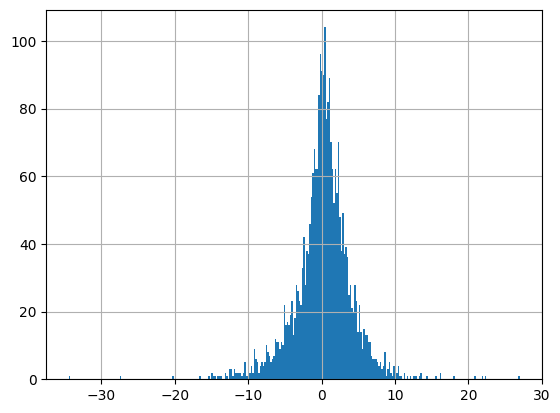

In [138]:
concat["tqqq actual change"].hist(bins=300)

# Histogram of Model daily change

<Axes: >

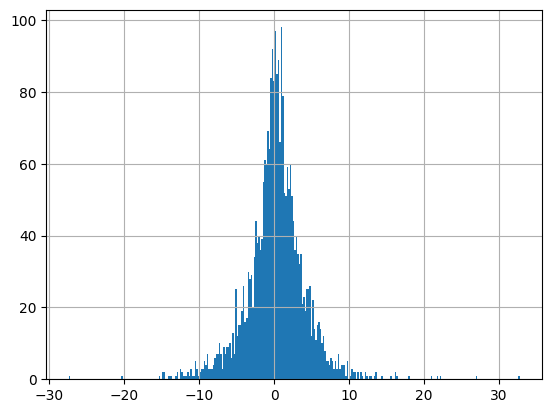

In [139]:
concat["Model_daily_change"].hist(bins=300)

# Histogram of Model minus tqqq

<Axes: >

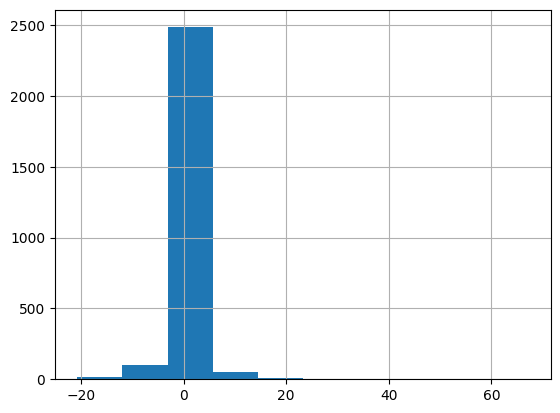

In [140]:
concat["Model minus tqqq"].hist(bins=10)
# plt.xlim(-5,5)

In [141]:
successful_days = concat[concat["Model minus tqqq"] > 0]
failure_days = concat[concat["Model minus tqqq"] < 0]
natural_days = concat[concat["Model minus tqqq"] == 0]
print(
    "successful_days",
    len(successful_days),
    "Average diff",
    successful_days["Model minus tqqq"].mean(),
    "%",
)
print(
    "failure_days",
    len(failure_days),
    "Average diff",
    failure_days["Model minus tqqq"].mean(),
    "%",
)
print(
    "natural_days",
    len(natural_days),
    "Average diff",
    natural_days["Model minus tqqq"].mean(),
    "%",
)

successful_days 189 Average diff 5.7362967524680135 %
failure_days 223 Average diff -4.553158185316746 %
natural_days 2255 Average diff 0.0 %


In [142]:
def calculate_S_squared(df, column_name):
    temp_df = df.copy()
    X_mean = temp_df[column_name].mean()
    temp_df["x_i-x_mean_squared"] = (temp_df[column_name] - X_mean) ** 2
    n = len(df)
    s_squared = temp_df["x_i-x_mean_squared"].sum() / (n - 1)
    return s_squared

In [143]:
columns_for_s = list(concat.columns)[-3:]
s_squared_lst = []
for column in columns_for_s:
    s_squared_lst.append(calculate_S_squared(concat, column))

In [144]:
Mu_0 = concat["tqqq actual change"].mean()
model_mean = concat["Model_daily_change"].mean()
n = len(concat)
t = 1.96
s = s_squared_lst[-1] ** 0.5
print("Mu_0 = " + str(Mu_0))
print("H1 : Mu > Mu_0")
print("s = " + str(s))
print("t test - n=inf (n>1000), 1-a/2 = 0.975 --> t = 1.96")
print("Mu Hat = " + str(model_mean) + " +- 1.96 * " + str(s) + "/" + str(n))
lower_bound = model_mean - t * s / (n**0.5)
upper_bound = model_mean + t * s / (n**0.5)
print("Model bounds are :" + "[" + str(lower_bound) + " , " + str(upper_bound) + "]")

Mu_0 = 0.2047294612183887
H1 : Mu > Mu_0
s = 3.018863561631546
t test - n=inf (n>1000), 1-a/2 = 0.975 --> t = 1.96
Mu Hat = 0.23052841543316954 +- 1.96 * 3.018863561631546/2667
Model bounds are :[0.1159538947899658 , 0.34510293607637327]


# Paired T-Test

In [145]:
a = list(range(1, 100))
b = list(range(201, 300))
print("two-sided", stats.ttest_rel(a, b, alternative="two-sided"))
print("less", stats.ttest_rel(a, b, alternative="less"))
print("greater", stats.ttest_rel(a, b, alternative="greater"))
print("\n")
print(
    'a values are much lower than b values.\n\
Therefore the P_value should be 0. As can be seen, the P_value is 0 for "less" test.\n\
Therefore, I will check less test and hope that the P_value will be lower than 0.05'
)

two-sided TtestResult(statistic=-inf, pvalue=0.0, df=98)
less TtestResult(statistic=-inf, pvalue=0.0, df=98)
greater TtestResult(statistic=-inf, pvalue=1.0, df=98)


a values are much lower than b values.
Therefore the P_value should be 0. As can be seen, the P_value is 0 for "less" test.
Therefore, I will check less test and hope that the P_value will be lower than 0.05


In [146]:
print(
    "two-sided",
    stats.ttest_rel(
        concat["tqqq actual change"],
        concat["Model_daily_change"],
        alternative="two-sided",
    ),
)
print(
    "less",
    stats.ttest_rel(
        concat["tqqq actual change"], concat["Model_daily_change"], alternative="less"
    ),
)
# print('greater',stats.ttest_rel(concat['tqqq actual change'], concat['Model_daily_change'],alternative = 'greater'))

two-sided TtestResult(statistic=-0.4413367821842146, pvalue=0.6590049910528004, df=2666)
less TtestResult(statistic=-0.4413367821842146, pvalue=0.3295024955264002, df=2666)


# Shapiro test to check if the data is from normal distribution

In [147]:
from scipy import stats

shapiro_test = stats.shapiro(concat["Model minus tqqq"])
shapiro_test

ShapiroResult(statistic=0.3554184093139442, pvalue=1.1336096393853837e-70)

In [148]:
x = np.random.normal(0, 1, 1000000)
shapiro_test = stats.shapiro(x)
shapiro_test

ShapiroResult(statistic=0.9999959978069553, pvalue=0.9904325102099752)

# Bootstrap sampling test - Calculate CI

In [149]:
concat_temp = concat.copy()
concat_temp = concat_temp[concat_temp["tqqq actual change"] > -12]
concat_temp

,Date,probability,tqqq actual change,sqqq actual change,qqq actual change,Model_daily_change,Model minus tqqq
0,2014-01-21,0.509851,2.237894,-2.375961,0.762410,2.237894,0.000000
1,2014-01-22,0.445401,0.927907,-0.858984,0.259735,0.927907,0.000000
2,2014-01-23,0.665502,-1.202259,1.227437,-0.337909,-1.202259,0.000000
3,2014-01-24,0.069133,-5.925378,5.920114,-1.966552,5.920114,11.845492
4,2014-01-27,0.582296,-2.908374,2.710438,-0.968407,-2.908374,0.000000
...,...,...,...,...,...,...,...
2662,2024-08-19,0.239772,3.875297,-3.645197,1.313599,3.875297,0.000000
2663,2024-08-20,0.413035,-0.617114,0.756620,-0.209857,-0.617114,0.000000
2664,2024-08-21,0.023552,1.368898,-1.627029,0.466412,-1.627029,-2.995927
2665,2024-08-22,0.107440,-4.803013,4.834601,-1.585491,4.834601,9.637614


In [150]:
concat.shape

(2667, 7)

In [151]:
array = concat["Model minus tqqq"].to_numpy()
# array = concat_temp['Model minus tqqq'].to_numpy()

In [152]:
n = len(array)
sampels = int(n / 2)
theta_star = array.mean()
bootstrap_lst = []
for i in range(sampels):
    bootstrap_lst.append(np.random.choice(array, size=n))
theta_star_b_lst = []
Expected_std = []
Expected_std_double_bootstrap = []
# Zb = (theta_star_b-theta_star)/(Se_star_theta_star_b)
for bootstrap in bootstrap_lst:
    thetha_double_star_b_array = np.array([])
    theta_star_b_lst.append(bootstrap.mean())
    Expected_std.append(bootstrap.std())

    for double_bootstrap in range(sampels):
        mean = np.random.choice(bootstrap, size=n).mean()
        thetha_double_star_b_array = np.append(thetha_double_star_b_array, mean)
    Expected_std_double_bootstrap.append(thetha_double_star_b_array.std())


print(sum(theta_star_b_lst) / len(theta_star_b_lst))
print(sum(Expected_std) / len(Expected_std))

0.024521550668679025
2.997843560885051


# Z = (Theta_hat - theta)/Se(theta_hat)

In [153]:
Zb = np.array([])
for i in range(len(theta_star_b_lst)):
    Zb = np.append(
        Zb, ((theta_star_b_lst[i] - theta_star) / Expected_std_double_bootstrap[i])
    )

In [154]:
t_alpha_divided_by_two = np.quantile(Zb, 0.025)
t_alpha_divided_by_two

-2.022015551432394

In [155]:
t_one_minus_alpha_divided_by_two = np.quantile(Zb, 1 - 0.025)
t_one_minus_alpha_divided_by_two

1.8267875220833747

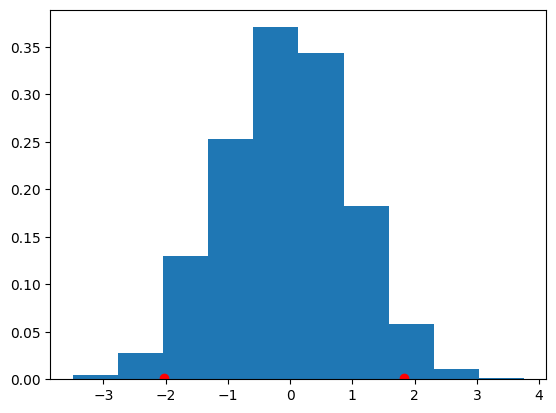

In [156]:
ax = plt.subplot(1, 1, 1)
ax.hist(Zb, density=True)
ax.plot(t_alpha_divided_by_two, 0.001, "or")
ax.plot(t_one_minus_alpha_divided_by_two, 0.001, "or")
plt.show()

#    Theta_hat - t_(1-a/2)*Se_hat(theta_hat)) < Theta < Theta_hat - t_(a/2)*Se_hat(theta_hat))

In [157]:
theta_hat = sum(theta_star_b_lst) / len(theta_star_b_lst)
Se_hat = np.array(theta_star_b_lst).std()
lower_bound = theta_hat - t_one_minus_alpha_divided_by_two * Se_hat
upper_bound = theta_hat - t_alpha_divided_by_two * Se_hat

In [158]:
print("lower bound:", lower_bound)
print("upper bound:", upper_bound)

lower bound: -0.0834378593821915
upper bound: 0.14401853836288547


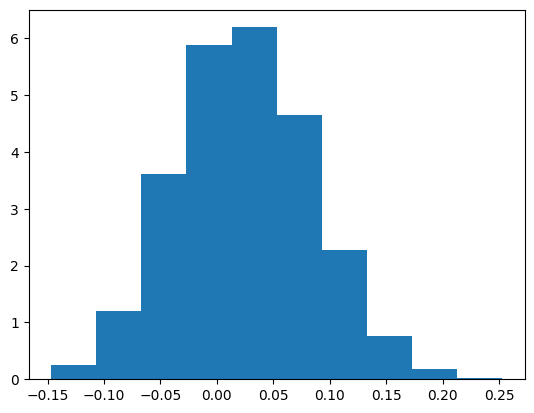

In [159]:
data = np.array(theta_star_b_lst)
plt.hist(data, density=True)
plt.show()

## Se = std of the first bootstrap results (std of the means)

# Quantile CI

In [160]:
alpha = 0.05
lower_ci = np.quantile(theta_star_b_lst, alpha / 2)
upper_ci = np.quantile(theta_star_b_lst, 1 - alpha / 2)
print("lower bound:", lower_ci)
print("upper bound:", upper_ci)

lower bound: -0.0872943458890501
upper bound: 0.14042591709226515


# Bootstrap - Hypothesis test

In [161]:
Di = array
Di_tilda = array - array.mean()
t = Di.mean() / (Di.std() / (len(Di) ** 0.5))
n = len(Di_tilda)
sampels = int(n * 20)
bootstrap_lst_tilda = []
for i in range(sampels):
    bootstrap_lst_tilda.append(np.random.choice(Di_tilda, size=n))


t_star_lst = []

for bootstrap in bootstrap_lst_tilda:
    d_tilda_mean = bootstrap.mean()
    s_d_tilda = bootstrap.std()
    t_star_lst.append(d_tilda_mean / (s_d_tilda / (n**0.5)))
counter_ALS = 0
for t_star in t_star_lst:
    if t_star > t:
        counter_ALS += 1

In [162]:
print("p value is:", counter_ALS / sampels)

p value is: 0.32435320584926886


In [163]:
# P Value almost 0 which means that my model is better than the nasdaq 100 index!

In [164]:
array = concat["Model minus tqqq"].to_numpy()
n = len(array)
sampels = int(n / 2)
bootstrap_lst = []
Expected_difference_lst = []
for i in range(sampels):
    bootstrap_lst.append(np.random.choice(array, size=n))
for bootstrap in bootstrap_lst:
    Expected_difference_lst.append(bootstrap.mean())
Expected_difference = sum(Expected_difference_lst) / len(Expected_difference_lst)
second_array = np.array(Expected_difference_lst) - Expected_difference
exp_std = ((second_array**2).sum() / (len(Expected_difference_lst) - 1)) ** 0.5

Expected_std = np.array(Expected_difference_lst).std()

print(Expected_difference)
print(Expected_std)
print(exp_std)
print("lower bound:", (Expected_difference - 3 * exp_std))
print("upper bound:", (Expected_difference + 3 * exp_std))

0.023588858433845648
0.0569356606931896
0.05695702892839235
lower bound: -0.1472822283513314
upper bound: 0.19445994521902268


In [165]:
from scipy.stats import bootstrap

data = (concat["Model minus tqqq"].to_numpy(),)
res_std = bootstrap(data, np.std, confidence_level=0.9, paired=True)
res_mean = bootstrap(data, np.mean, confidence_level=0.9, paired=True)

In [166]:
print("std CI", res_std.confidence_interval)
print("mean CI", res_mean.confidence_interval)

std CI ConfidenceInterval(low=2.6529147452705764, high=3.8096349025255924)
mean CI ConfidenceInterval(low=-0.06572897074854236, high=0.12738073830629537)


# Manual bootstrap sampling

In [167]:
bootstrap_df_lst = []
n = 2000
sampels = int(n)
for i in range(sampels):
    bootstrap_df_lst.append(concat.sample(n=n, replace=True))

# mean and std for the difference between my model and tqqq

In [168]:
mean_lst = []
std_lst = []
for df in bootstrap_df_lst:
    mean_lst.append(df["Model minus tqqq"].mean())
    std_lst.append(df["Model minus tqqq"].std())
mean_array = np.asarray(mean_lst)
std_array = np.asarray(std_lst)

In [169]:
# Mean details
print(mean_array.mean())
print(mean_array.std())

0.024518734596523945
0.06762641283458617


In [170]:
# STD details
print(std_array.mean())
print(std_array.std())

2.992535950939808
0.34818097844027823


# T-tests for the bootstrap sampling

In [171]:
P_value_lst = []
statistic_lst = []
for df in bootstrap_df_lst:
    ttest = stats.ttest_rel(
        df["tqqq actual change"], df["Model_daily_change"], alternative="less"
    )
    P_value_lst.append(ttest.pvalue)
    statistic_lst.append(ttest.statistic)
P_value_array = np.asarray(P_value_lst)
statistic_array = np.asarray(statistic_lst)

In [172]:
np.asarray(P_value_lst).mean()

0.4059298473955104

# Calculate profit according to the Model daily change column

# Statistics of positive days

In [173]:
concat[concat["tqqq actual change"] > 0].describe()

,Date,probability,tqqq actual change,sqqq actual change,qqq actual change,Model_daily_change,Model minus tqqq
count,1490,1490.000000,1490.000000,1490.000000,1490.000000,1490.000000,1490.000000
mean,2019-05-01 15:25:51.140939520,0.575700,2.653008,-2.669466,0.897188,1.971854,-0.681154
min,2014-01-21 00:00:00,0.004240,0.006880,-28.354509,-0.157234,-10.396313,-20.728419
25%,2016-09-28 12:00:00,0.273984,0.869241,-3.596799,0.289948,0.402250,0.000000
50%,2019-05-01 00:00:00,0.635977,1.978751,-2.005168,0.661127,1.509942,0.000000
75%,2021-10-26 18:00:00,0.885349,3.572716,-0.857234,1.207287,3.311512,0.000000
max,2024-08-23 00:00:00,0.998452,26.988388,0.545703,8.470555,26.988388,0.235929
std,NaN,0.325547,2.642632,2.674344,0.902097,3.184951,2.257547


# Statistics of negative days

In [174]:
concat[concat["tqqq actual change"] < 0].describe()

,Date,probability,tqqq actual change,sqqq actual change,qqq actual change,Model_daily_change,Model minus tqqq
count,1171,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000
mean,2019-05-10 20:10:02.561912832,0.559460,-2.909452,2.898679,-0.975791,-1.983982,0.925470
min,2014-01-23 00:00:00,0.004996,-34.465166,-0.608696,-11.978784,-27.408371,0.000000
25%,2016-08-17 12:00:00,0.250650,-4.127311,0.766494,-1.378416,-3.479829,0.000000
50%,2019-05-08 00:00:00,0.599658,-1.864174,1.867220,-0.634999,-1.368386,0.000000
75%,2022-02-22 12:00:00,0.862948,-0.771388,4.062741,-0.254523,-0.292086,0.000000
max,2024-08-22 00:00:00,0.999061,-0.008791,32.742215,0.084170,32.742215,67.207380
std,NaN,0.322779,3.141503,3.129271,1.059856,3.779340,3.582422


In [175]:
concat_2 = concat.iloc[-37:]
(
    len(
        concat_2[
            (concat_2["probability"] > 0.15) & (concat_2["tqqq actual change"] > 0)
        ]
    )
    + len(
        concat_2[
            (concat_2["probability"] < 0.15) & (concat_2["tqqq actual change"] < 0)
        ]
    )
) / len(concat_2)

0.5135135135135135

In [176]:
concat_2

,Date,probability,tqqq actual change,sqqq actual change,qqq actual change,Model_daily_change,Model minus tqqq
2630,2024-07-03,0.755372,2.457004,-2.411168,0.833709,2.457004,0.000000
2631,2024-07-05,0.014705,3.029148,-3.120939,1.042684,-3.120939,-6.150087
2632,2024-07-08,0.160128,0.661523,-0.671137,0.237825,0.661523,0.000000
2633,2024-07-09,0.031931,0.219058,-0.135138,0.086458,-0.135138,-0.354197
2634,2024-07-10,0.066668,3.132971,-2.976993,1.042651,-2.976993,-6.109964
2635,2024-07-11,0.619677,-6.570119,6.415621,-2.193017,-6.570119,0.000000
2636,2024-07-12,0.512211,1.625710,-1.572738,0.587485,1.625710,0.000000
2637,2024-07-15,0.978735,0.744046,-0.665781,0.268782,0.744046,0.000000
2638,2024-07-16,0.987558,0.073862,0.000000,0.038295,0.073862,0.000000
2639,2024-07-17,0.835150,-8.794589,8.713132,-2.935489,-8.794589,0.000000


In [177]:
len(
    concat_2[(concat_2["probability"] > 0.15) & (concat_2["tqqq actual change"] > 0)]
) / len(concat_2[concat_2["probability"] > 0.15])

0.5806451612903226

In [178]:
len(
    concat_2[(concat_2["probability"] < 0.15) & (concat_2["tqqq actual change"] < 0)]
) / len(concat_2[concat_2["probability"] < 0.15])

0.16666666666666666

In [179]:
concat_2[(concat_2["probability"] < 0.15) & (concat_2["tqqq actual change"] < 0)]

,Date,probability,tqqq actual change,sqqq actual change,qqq actual change,Model_daily_change,Model minus tqqq
2665,2024-08-22,0.10744,-4.803013,4.834601,-1.585491,4.834601,9.637614


In [180]:
# Accuracy ratio
(
    len(concat[(concat["probability"] > 0.15) & (concat["tqqq actual change"] > 0)])
    + len(concat[(concat["probability"] < 0.15) & (concat["tqqq actual change"] < 0)])
) / len(concat)

0.5436820397450318

[[<Axes: title={'center': 'Date'}>
  <Axes: title={'center': 'probability'}>
  <Axes: title={'center': 'tqqq actual change'}>]
 [<Axes: title={'center': 'sqqq actual change'}>
  <Axes: title={'center': 'qqq actual change'}>
  <Axes: title={'center': 'Model_daily_change'}>]
 [<Axes: title={'center': 'Model minus tqqq'}> <Axes: > <Axes: >]]
[[<Axes: title={'center': 'Date'}>
  <Axes: title={'center': 'probability'}>
  <Axes: title={'center': 'tqqq actual change'}>]
 [<Axes: title={'center': 'sqqq actual change'}>
  <Axes: title={'center': 'qqq actual change'}>
  <Axes: title={'center': 'Model_daily_change'}>]
 [<Axes: title={'center': 'Model minus tqqq'}> <Axes: > <Axes: >]]
[[<Axes: title={'center': 'Date'}>
  <Axes: title={'center': 'probability'}>
  <Axes: title={'center': 'tqqq actual change'}>]
 [<Axes: title={'center': 'sqqq actual change'}>
  <Axes: title={'center': 'qqq actual change'}>
  <Axes: title={'center': 'Model_daily_change'}>]
 [<Axes: title={'center': 'Model minus tqqq'

,Probability,Number of rows,Accuracy ratio,Average change %
0,"[0, 0.05]",155,0.406452,-0.010835
1,"[0.05, 0.15]",257,0.478599,-0.132661
2,"[0.15, 0.25]",219,0.520548,-0.28034
3,"[0.25, 0.35]",207,0.574879,0.623091
4,"[0.35, 0.45]",184,0.586957,0.490517
5,"[0.45, 0.55]",184,0.5,-0.098178
6,"[0.55, 0.65]",181,0.563536,0.567899
7,"[0.65, 0.75]",226,0.561947,0.083341
8,"[0.75, 0.85]",297,0.521886,-0.0199
9,"[0.85, 0.95]",387,0.602067,0.363212


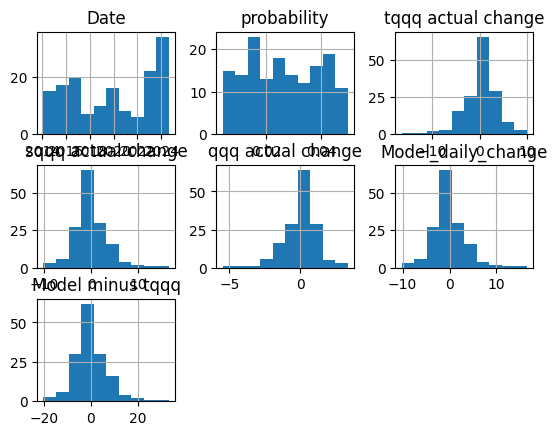

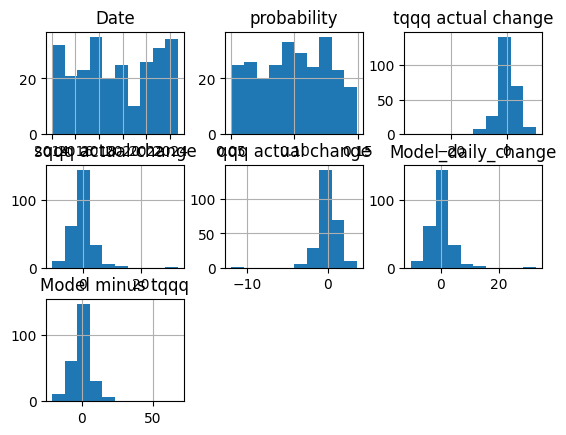

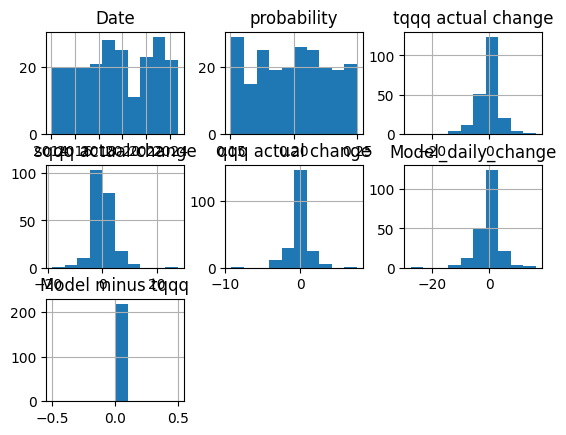

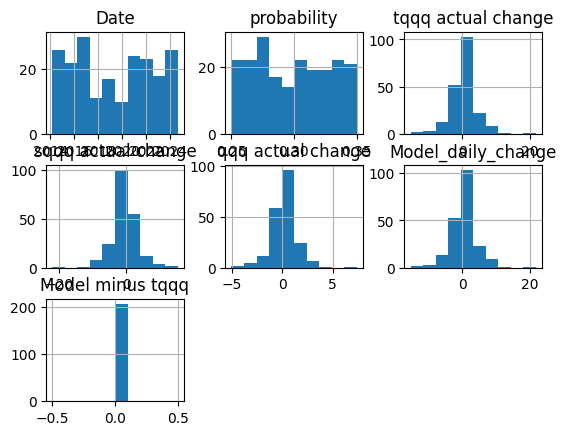

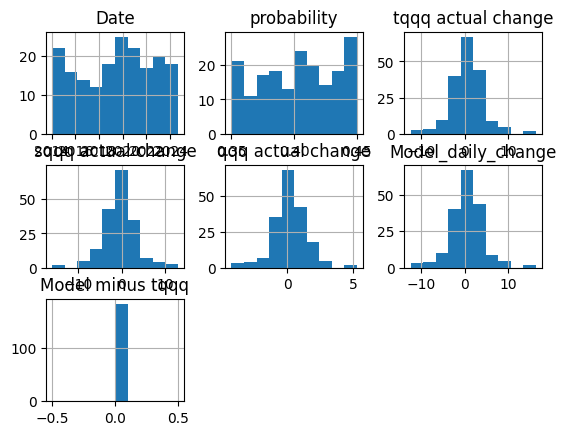

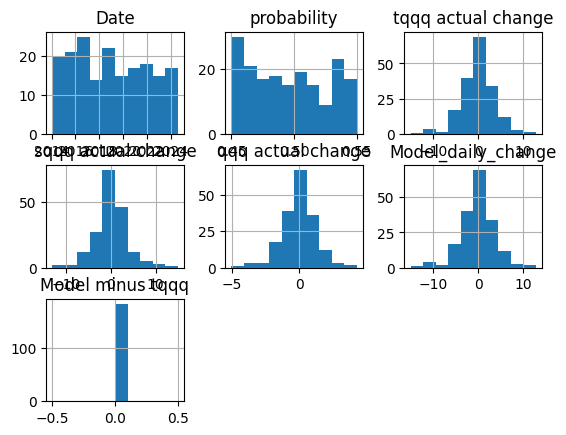

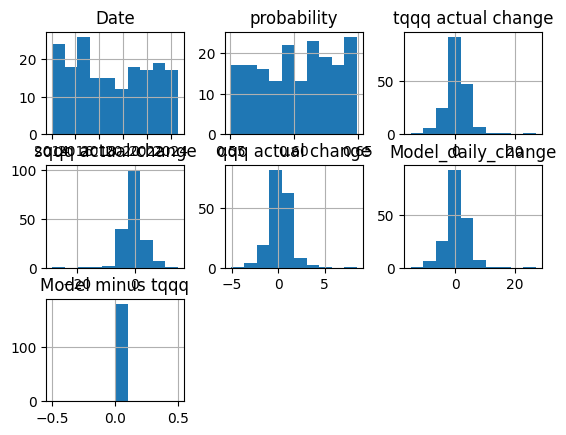

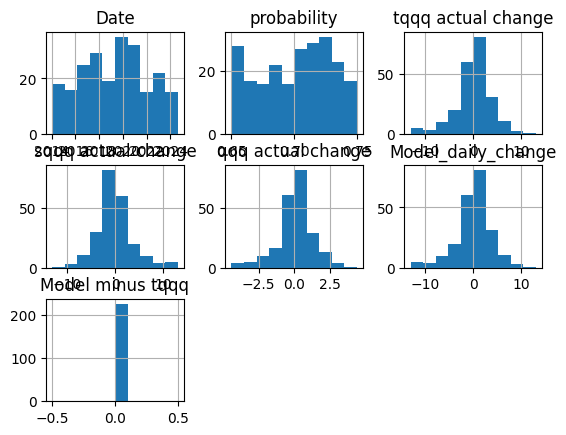

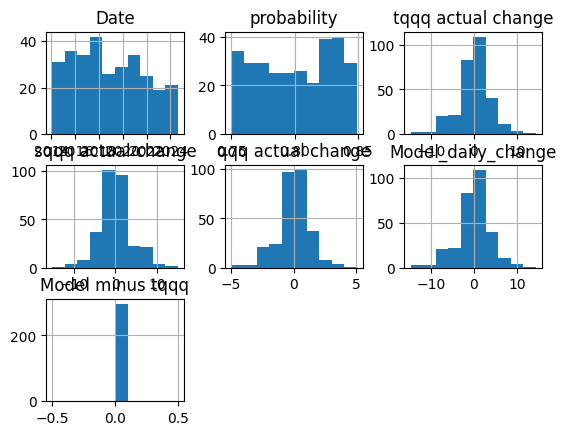

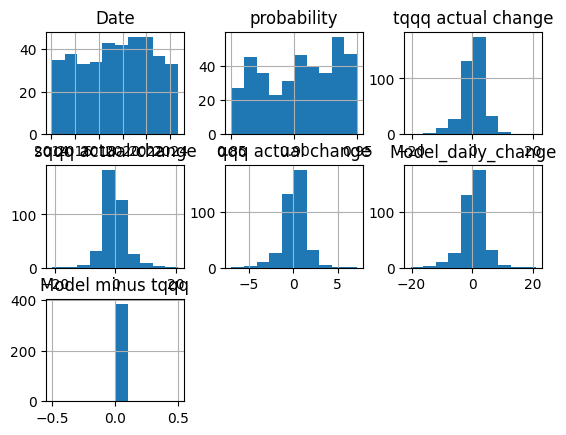

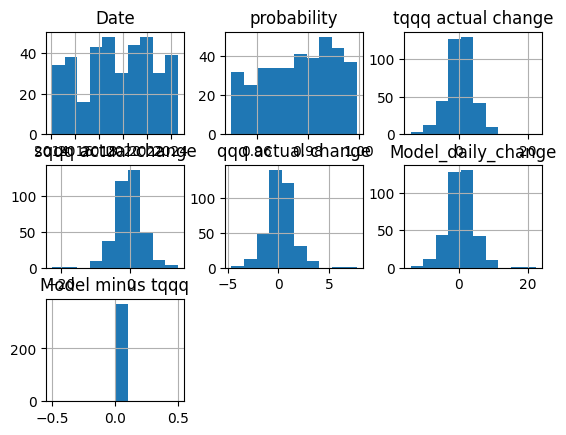

In [181]:
ratio_ranges = [
    [0, 0.05],
    [0.05, 0.15],
    [0.15, 0.25],
    [0.25, 0.35],
    [0.35, 0.45],
    [0.45, 0.55],
    [0.55, 0.65],
    [0.65, 0.75],
    [0.75, 0.85],
    [0.85, 0.95],
    [0.95, 1],
]
acc_lst = []
change_lst = []
num_of_rows_lst = []
for ratio_range in ratio_ranges:
    temp_df = concat[
        (concat["probability"] >= ratio_range[0])
        & (concat["probability"] <= ratio_range[1])
    ]
    lenght = len(temp_df)
    if ratio_range[0] <= 0.05:
        accuracy = len(temp_df[temp_df["tqqq actual change"] < 0])
        accuracy /= lenght
    else:
        accuracy = len(temp_df[temp_df["tqqq actual change"] > 0])
        accuracy /= lenght
    avg_change = temp_df["tqqq actual change"].mean()
    acc_lst.append(accuracy)
    change_lst.append(avg_change)
    num_of_rows_lst.append(lenght)
    print(temp_df.hist())
summary_df = pd.DataFrame(
    [ratio_ranges, num_of_rows_lst, acc_lst, change_lst]
).T.rename(
    columns={
        0: "Probability",
        1: "Number of rows",
        2: "Accuracy ratio",
        3: "Average change %",
    }
)
summary_df

In [182]:
property_asel = [y_test_label[i] for i in short_indexes]
short_label_df = pd.DataFrame(property_asel[0])
for i in property_asel[1:]:
    temp = pd.DataFrame(i)
    short_label_df = pd.concat([short_label_df, temp])

In [183]:
short_label_df.describe()

,tqqq_change_for_1_day
count,412.000000
mean,-0.086828
std,3.864347
min,-34.465166
25%,-1.503241
50%,0.222076
75%,2.012130
max,10.332105


In [184]:
property_asel_long = [y_test_label[i] for i in long_indexes]
long_label_df = pd.DataFrame(property_asel_long[0])
for i in property_asel_long[1:]:
    temp = pd.DataFrame(i)
    long_label_df = pd.concat([long_label_df, temp])

In [185]:
long_label_df.describe()

,tqqq_change_for_1_day
count,2255.000000
mean,0.257999
std,3.999455
min,-27.408371
25%,-1.473514
50%,0.375636
75%,2.263072
max,26.988388


In [186]:
((long_label_df > 0).sum()) / len(long_label_df)

tqqq_change_for_1_day    0.560532
dtype: float64

In [187]:
((short_label_df < 0).sum()) / len(short_label_df)

tqqq_change_for_1_day    0.451456
dtype: float64

In [188]:
long_label_df.iloc[-383:-163]

,tqqq_change_for_1_day
Date,
2022-09-06,-2.286359
2022-09-07,5.907177
2022-09-08,1.629840
2022-09-12,3.652816
2022-09-15,-5.034065
...,...
2023-09-22,0.084277
2023-09-25,1.319106
2023-09-28,2.420750


In [189]:
((short_label_df < 0).sum()) / len(short_label_df)

tqqq_change_for_1_day    0.451456
dtype: float64

In [190]:
short_label_df.tail(35)

,tqqq_change_for_1_day
Date,
2024-01-29,2.940117
2024-01-31,-5.882355
2024-02-01,3.533436
2024-02-06,-0.579459
2024-02-13,-4.734721
2024-02-15,0.837031
2024-02-16,-2.744366
2024-02-20,-2.316666
2024-02-21,-1.248218


In [191]:
len(short_indexes) / (len(long_indexes) + len(short_indexes))

0.1544806899137608

In [192]:
all_test_label_qqq = qqq_y_test_label[0]
for df in qqq_y_test_label[1:]:
    all_test_label_qqq = pd.concat([all_test_label_qqq, df])
# all_test_label_qqq

In [193]:
all_test_data = y_test_sets[0]
for df in y_test_sets[1:]:
    all_test_data = pd.concat([all_test_data, df])
# all_test_data

In [194]:
temp_df = all_test_data.copy()
temp_df["probability_for_date"] = list(y_proba_df["probability"])
temp_df = pd.DataFrame(temp_df["probability_for_date"])
temp_df.tail(29)

,probability_for_date
Date,
2024-07-16,0.987558
2024-07-17,0.835150
2024-07-18,0.159009
2024-07-19,0.344883
2024-07-22,0.979407
2024-07-23,0.822569
2024-07-24,0.826666
2024-07-25,0.746478
2024-07-26,0.506144


In [195]:
y_test_label[1530]

Date
2020-02-19    2.893498
Name: tqqq_change_for_1_day, dtype: float64

In [196]:
all_test_label = y_test_label[0]
for df in y_test_label[1:]:
    all_test_label = pd.concat([all_test_label, df])
all_test_label.tail(20)

Date
2024-07-29    0.583893
2024-07-30   -4.078824
2024-07-31    8.743427
2024-08-01   -7.205621
2024-08-02   -7.291665
2024-08-05   -8.716382
2024-08-06    2.499068
2024-08-07   -3.220525
2024-08-08    9.155862
2024-08-09    1.360656
2024-08-12    0.679697
2024-08-13    7.274264
2024-08-14    0.173060
2024-08-15    7.523168
2024-08-16    0.262928
2024-08-19    3.875297
2024-08-20   -0.617114
2024-08-21    1.368898
2024-08-22   -4.803013
2024-08-23    3.144197
Name: tqqq_change_for_1_day, dtype: float64

In [197]:
def calculate_tracking_indexes(starting_money, qqq_lst, tqqq_lst):
    beggining_money = starting_money
    end_money_just_long_tqqq = beggining_money
    end_money_just_long_qqq = beggining_money
    just_long_list_tqqq = [starting_money]
    just_long_list_qqq = [starting_money]
    y_in_percentage_test = list(tqqq_lst)
    qqq_y_in_percentage_test = list(qqq_lst)
    for i in range(len(qqq_lst)):
        end_money_just_long_tqqq *= (100 + list(y_in_percentage_test)[i]) / 100
        end_money_just_long_qqq *= (100 + list(qqq_y_in_percentage_test)[i]) / 100

        just_long_list_tqqq.append(end_money_just_long_tqqq)
        just_long_list_qqq.append(end_money_just_long_qqq)

    return just_long_list_tqqq, just_long_list_qqq

In [198]:
def calculate_yearly_profit(df):
    profit_dict = {}
    for i, row in df.iterrows():
        if row["Year and month"][:4] not in profit_dict:
            profit_dict[row["Year and month"][:4]] = [
                [row["TQQQ_long"]],
                [row["QQQ_long"]],
                [row["Model"]],
            ]
        else:
            profit_dict[row["Year and month"][:4]][0].append(row["TQQQ_long"])
            profit_dict[row["Year and month"][:4]][1].append(row["QQQ_long"])
            profit_dict[row["Year and month"][:4]][2].append(row["Model"])
    for key in profit_dict.keys():
        profit_dict[key][0] = np.prod(profit_dict[key][0])
        profit_dict[key][1] = np.prod(profit_dict[key][1])
        profit_dict[key][2] = np.prod(profit_dict[key][2])

    return profit_dict

In [199]:
just_long_list_tqqq, just_long_list_qqq = calculate_tracking_indexes(
    100, all_test_label_qqq, all_test_label
)

In [200]:
print(money_list[-1] / money_list[0], "MODEL")
print(just_long_list_tqqq[-1] / just_long_list_tqqq[0], "TQQQ")
print(just_long_list_qqq[-1] / just_long_list_qqq[0], "QQQ")

56.97122516345913 MODEL
27.450254529662907 TQQQ
5.461993798382053 QQQ


Here is a graph between the close price of 2014-01-20 until the close price of 2021-11-09
My model- Blue
TQQQ stock- red


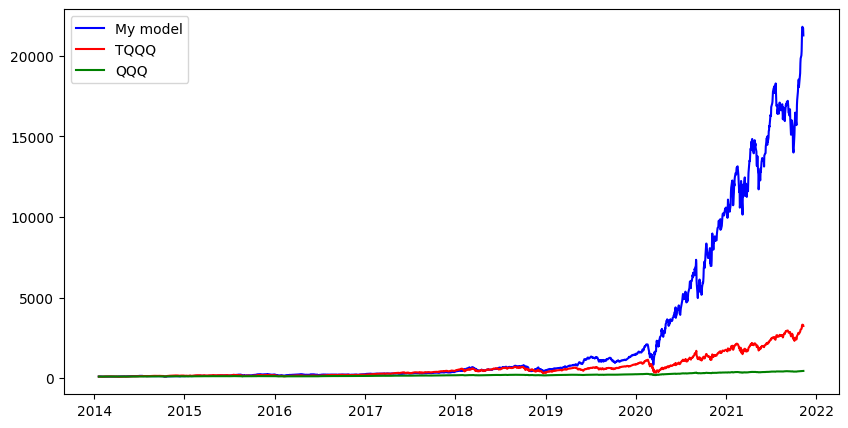

Model performance during this period: 203.3785452303386
TQQQ performance during this period: 30.954999749460427
QQQ performance during this period: 4.4322942869741215


In [201]:
plt.rcParams["figure.figsize"] = (10, 5)
min_index = -len(money_list)
from_index = min_index
until = -700
money_list_temp = list(np.array(money_list) * 100 / money_list[from_index])
just_long_list_tqqq_temp = list(
    np.array(just_long_list_tqqq) * 100 / just_long_list_tqqq[from_index]
)
just_long_list_qqq_temp = list(
    np.array(just_long_list_qqq) * 100 / just_long_list_qqq[from_index]
)
if until == -1:

    plot_lineplot(
        list(all_test_data.index)[from_index + 1 :],
        money_list_temp[from_index:],
        just_long_list_tqqq_temp[from_index:],
        just_long_list_qqq_temp[from_index:],
    )
    print(
        "Model performance during this period:",
        money_list_temp[until] / money_list_temp[from_index],
    )
    print(
        "TQQQ performance during this period:",
        just_long_list_tqqq_temp[until] / just_long_list_tqqq_temp[from_index],
    )
    print(
        "QQQ performance during this period:",
        just_long_list_qqq_temp[until] / just_long_list_qqq_temp[from_index],
    )
else:
    plot_lineplot(
        list(all_test_data.index)[from_index + 1 : until],
        money_list_temp[from_index:until],
        just_long_list_tqqq_temp[from_index:until],
        just_long_list_qqq_temp[from_index:until],
    )
    print(
        "Model performance during this period:",
        money_list_temp[until] / money_list_temp[from_index],
    )
    print(
        "TQQQ performance during this period:",
        just_long_list_tqqq_temp[until] / just_long_list_tqqq_temp[from_index],
    )
    print(
        "QQQ performance during this period:",
        just_long_list_qqq_temp[until] / just_long_list_qqq_temp[from_index],
    )

Here is a graph between the close price of 2023-09-12 until the close price of 2024-08-23
My model- Blue
TQQQ stock- red


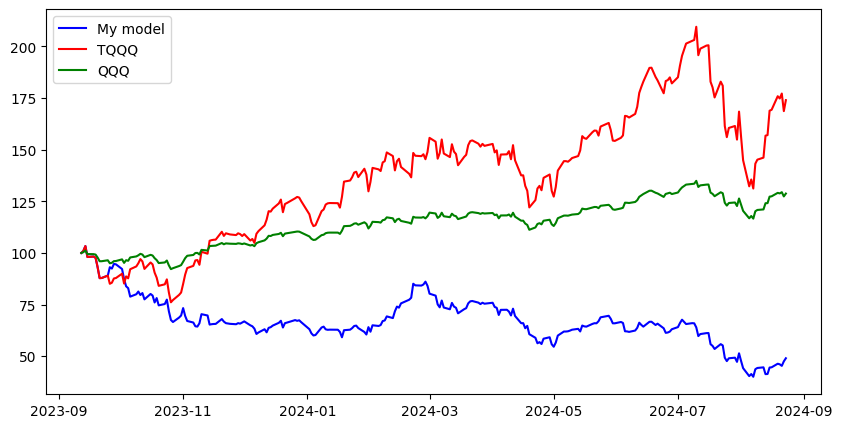

Model performance during this period: 0.4903455912323756
TQQQ performance during this period: 1.7397631274419376
QQQ performance during this period: 1.2875881568648821


In [202]:
plt.rcParams["figure.figsize"] = (10, 5)
min_index = -len(money_list)
from_index = -240
until = -1
money_list_temp = list(np.array(money_list) * 100 / money_list[from_index])
just_long_list_tqqq_temp = list(
    np.array(just_long_list_tqqq) * 100 / just_long_list_tqqq[from_index]
)
just_long_list_qqq_temp = list(
    np.array(just_long_list_qqq) * 100 / just_long_list_qqq[from_index]
)
if until == -1:

    plot_lineplot(
        list(all_test_data.index)[from_index + 1 :],
        money_list_temp[from_index:],
        just_long_list_tqqq_temp[from_index:],
        just_long_list_qqq_temp[from_index:],
    )
    print(
        "Model performance during this period:",
        money_list_temp[until] / money_list_temp[from_index],
    )
    print(
        "TQQQ performance during this period:",
        just_long_list_tqqq_temp[until] / just_long_list_tqqq_temp[from_index],
    )
    print(
        "QQQ performance during this period:",
        just_long_list_qqq_temp[until] / just_long_list_qqq_temp[from_index],
    )
else:
    plot_lineplot(
        list(all_test_data.index)[from_index + 1 : until],
        money_list_temp[from_index:until],
        just_long_list_tqqq_temp[from_index:until],
        just_long_list_qqq_temp[from_index:until],
    )
    print(
        "Model performance during this period:",
        money_list_temp[until] / money_list_temp[from_index],
    )
    print(
        "TQQQ performance during this period:",
        just_long_list_tqqq_temp[until] / just_long_list_tqqq_temp[from_index],
    )
    print(
        "QQQ performance during this period:",
        just_long_list_qqq_temp[until] / just_long_list_qqq_temp[from_index],
    )

Here is a graph between the close price of 2024-04-15 until the close price of 2024-08-23
My model- Blue
TQQQ stock- red


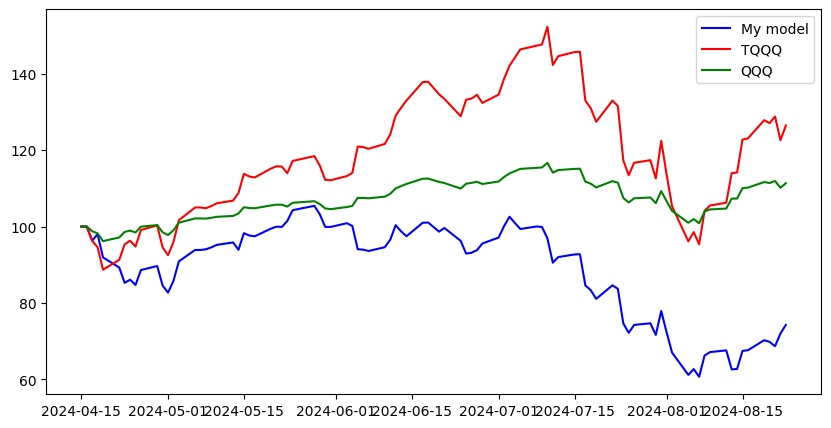

Model performance during this period: 0.7428333253755076
TQQQ performance during this period: 1.2646583862360081
QQQ performance during this period: 1.1135340850892876


In [204]:
plt.rcParams["figure.figsize"] = (10, 5)
min_index = -len(money_list)
from_index = -92
until = -1
money_list_temp = list(np.array(money_list) * 100 / money_list[from_index])
just_long_list_tqqq_temp = list(
    np.array(just_long_list_tqqq) * 100 / just_long_list_tqqq[from_index]
)
just_long_list_qqq_temp = list(
    np.array(just_long_list_qqq) * 100 / just_long_list_qqq[from_index]
)
if until == -1:

    plot_lineplot(
        list(all_test_data.index)[from_index + 1 :],
        money_list_temp[from_index:],
        just_long_list_tqqq_temp[from_index:],
        just_long_list_qqq_temp[from_index:],
    )
    print(
        "Model performance during this period:",
        money_list_temp[until] / money_list_temp[from_index],
    )
    print(
        "TQQQ performance during this period:",
        just_long_list_tqqq_temp[until] / just_long_list_tqqq_temp[from_index],
    )
    print(
        "QQQ performance during this period:",
        just_long_list_qqq_temp[until] / just_long_list_qqq_temp[from_index],
    )
else:
    plot_lineplot(
        list(all_test_data.index)[from_index + 1 : until],
        money_list_temp[from_index:until],
        just_long_list_tqqq_temp[from_index:until],
        just_long_list_qqq_temp[from_index:until],
    )
    print(
        "Model performance during this period:",
        money_list_temp[until] / money_list_temp[from_index],
    )
    print(
        "TQQQ performance during this period:",
        just_long_list_tqqq_temp[until] / just_long_list_tqqq_temp[from_index],
    )
    print(
        "QQQ performance during this period:",
        just_long_list_qqq_temp[until] / just_long_list_qqq_temp[from_index],
    )

In [205]:
short_label_df.tail(5)

,tqqq_change_for_1_day
Date,
2024-07-09,0.219058
2024-07-10,3.132971
2024-08-13,7.274264
2024-08-21,1.368898
2024-08-22,-4.803013


# Performences of stupid model

In [206]:
# for i in range(1,100):
#     np.random.seed(i)
#     stupid_end_money,stupid_change_in_ratio,stupid_short_indexes,stupid_long_indexes,stupid_commission, stupid_money_list, stupid_just_long_list,stupid_just_long_list_qqq, stupid_y_proba = calculate_how_much_money_stupid_model_will_have(100,0.15, concat['tqqq actual change'],concat['qqq actual change'], concat['qqq actual change'],with_short=True)
#     short_stupid = concat.iloc[stupid_short_indexes]
#     long_stupid = concat.iloc[stupid_long_indexes]
#     acc = ((long_stupid['tqqq actual change']>0).sum() + (short_stupid['tqqq actual change']<0).sum())/len(concat)
#     short_ratio = len(stupid_short_indexes)/(len(stupid_short_indexes)+len(stupid_long_indexes))
#     if 0.56<acc<0.57 and 0.13<short_ratio<0.14:
#         print(i)
#         print(acc,short_ratio)


# 3
# 0.5662955465587044 0.1396761133603239
# 72
# 0.5612348178137652 0.13512145748987855

In [207]:
np.random.seed(72)
(
    stupid_end_money,
    stupid_change_in_ratio,
    stupid_short_indexes,
    stupid_long_indexes,
    stupid_commission,
    stupid_money_list,
    stupid_just_long_list,
    stupid_just_long_list_qqq,
    stupid_y_proba,
) = calculate_how_much_money_stupid_model_will_have(
    100,
    0.15,
    concat["tqqq actual change"],
    concat["qqq actual change"],
    concat["qqq actual change"],
    with_short=True,
)

In [208]:
short_stupid = concat.iloc[stupid_short_indexes]
long_stupid = concat.iloc[stupid_long_indexes]

In [209]:
# accuracy ratio of stupid model that predicts a negative day
len(short_stupid[short_stupid["tqqq actual change"] < 0]) / len(short_stupid)

0.4410958904109589

In [210]:
# accuracy ratio of stupid model
(
    (long_stupid["tqqq actual change"] > 0).sum()
    + (short_stupid["tqqq actual change"] < 0).sum()
) / len(concat)

0.5429321334833146

In [211]:
# ratio of stupid predicting negative days
len(stupid_short_indexes) / (len(stupid_short_indexes) + len(stupid_long_indexes))

0.13685789276340457

In [212]:
# my model ratio of predicting negative days
len(short_indexes) / (len(long_indexes) + len(short_indexes))

0.1544806899137608

Here is a graph between the close price of 2014-01-20 until the close price of 2024-08-23
My model- Blue
TQQQ stock- red


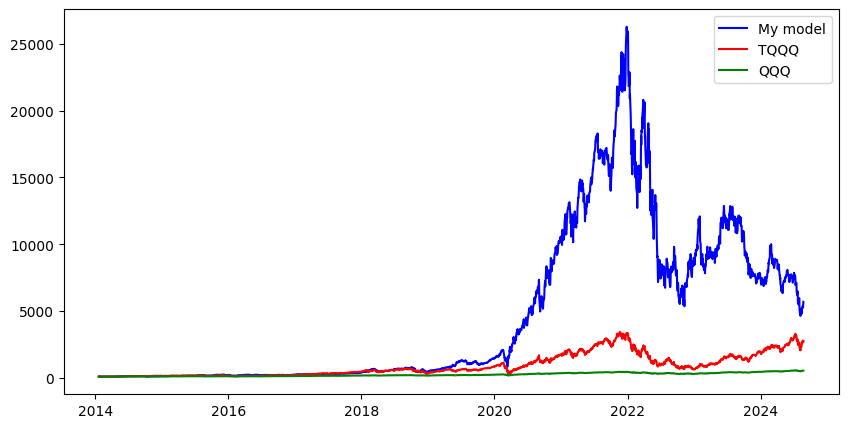

Model performance during this period: 56.97122516345913
TQQQ performance during this period: 27.450254529662907
QQQ performance during this period: 5.461993798382053
Stupid model performance during this period: 19.51141701588286


In [213]:
plt.rcParams["figure.figsize"] = (10, 5)
from_index = 0
money_list_temp = list(np.array(money_list) * 100 / money_list[from_index])
just_long_list_tqqq_temp = list(
    np.array(just_long_list_tqqq) * 100 / just_long_list_tqqq[from_index]
)
just_long_list_qqq_temp = list(
    np.array(just_long_list_qqq) * 100 / just_long_list_qqq[from_index]
)

plot_lineplot(
    list(all_test_data.index)[from_index:],
    money_list_temp[from_index:],
    just_long_list_tqqq_temp[from_index:],
    just_long_list_qqq_temp[from_index:],
)
print(
    "Model performance during this period:",
    money_list_temp[-1] / money_list_temp[from_index],
)
print(
    "TQQQ performance during this period:",
    just_long_list_tqqq_temp[-1] / just_long_list_tqqq_temp[from_index],
)
print(
    "QQQ performance during this period:",
    just_long_list_qqq_temp[-1] / just_long_list_qqq_temp[from_index],
)
print(
    "Stupid model performance during this period:",
    stupid_money_list[-1] / stupid_money_list[from_index],
)

In [214]:
len(just_long_list_tqqq_temp)

2668

In [215]:
money_list_temp[-1] / money_list_temp[0]

56.97122516345913

In [216]:
len(just_long_list_tqqq)

2668

In [217]:
table = create_a_comparing_table(
    100, money_list, just_long_list_tqqq, just_long_list_qqq, all_test_label_qqq.index
)
table

,Year and month,TQQQ_long,QQQ_long,Model,TQQQ vs Model,QQQ vs Model
0,2014 January,0.942350,0.981680,1.061007,Model,Model
1,2014 February,1.154018,1.047177,0.936118,TQQQ,QQQ
2,2014 March,0.916344,0.970445,1.002707,Model,Model
3,2014 April,0.979658,0.996806,1.143194,Model,Model
4,2014 May,1.135050,1.044856,1.108720,TQQQ,Model
...,...,...,...,...,...,...
123,2024 April,0.856725,0.956262,0.739883,TQQQ,QQQ
124,2024 May,1.185628,1.061518,1.181579,TQQQ,Model
125,2024 June,1.180553,1.063012,0.956558,TQQQ,QQQ
126,2024 July,0.924953,0.983219,0.815321,TQQQ,QQQ


In [218]:
table.describe()

,TQQQ_long,QQQ_long,Model
count,128.000000,128.000000,128.000000
mean,1.039505,1.014719,1.047233
std,0.162852,0.052547,0.177583
min,0.618701,0.864043,0.580625
25%,0.929230,0.981524,0.948672
50%,1.050977,1.019090,1.037056
75%,1.147614,1.047907,1.149411
max,1.464526,1.149737,1.737568


In [219]:
range_to_choose = range(9, table.shape[0], 12)
table.iloc[range_to_choose]

,Year and month,TQQQ_long,QQQ_long,Model,TQQQ vs Model,QQQ vs Model
9,2014 October,1.065773,1.026420,0.903837,TQQQ,QQQ
21,2015 October,1.372290,1.113699,1.352607,TQQQ,Model
33,2016 October,0.953884,0.985428,0.963573,Model,QQQ
45,2017 October,1.137418,1.046064,1.091454,TQQQ,Model
57,2018 October,0.733905,0.914043,0.580625,TQQQ,QQQ
69,2019 October,1.124290,1.043801,0.944382,TQQQ,QQQ
81,2020 October,0.897250,0.969551,1.159672,Model,Model
93,2021 October,1.245565,1.078640,1.416589,Model,Model
105,2022 October,1.084369,1.039999,0.952953,TQQQ,QQQ
117,2023 October,0.920270,0.979345,0.737793,TQQQ,QQQ


In [220]:
table.iloc[[56, 57, 58, 59, 73, 74, 80, 92]]

,Year and month,TQQQ_long,QQQ_long,Model,TQQQ vs Model,QQQ vs Model
56,2018 September,0.983956,0.995392,0.989484,Model,QQQ
57,2018 October,0.733905,0.914043,0.580625,TQQQ,QQQ
58,2018 November,0.970887,0.997350,1.436460,Model,Model
59,2018 December,0.730716,0.910787,0.744179,Model,QQQ
73,2020 February,0.822298,0.939426,0.753332,TQQQ,QQQ
74,2020 March,0.618701,0.925170,1.737568,Model,Model
80,2020 September,0.811230,0.942214,0.860033,Model,QQQ
92,2021 September,0.833300,0.942124,0.827699,TQQQ,QQQ


In [221]:
table.head(44)

,Year and month,TQQQ_long,QQQ_long,Model,TQQQ vs Model,QQQ vs Model
0,2014 January,0.942350,0.981680,1.061007,Model,Model
1,2014 February,1.154018,1.047177,0.936118,TQQQ,QQQ
2,2014 March,0.916344,0.970445,1.002707,Model,Model
3,2014 April,0.979658,0.996806,1.143194,Model,Model
4,2014 May,1.135050,1.044856,1.108720,TQQQ,Model
5,2014 June,1.094395,1.028474,1.074070,TQQQ,Model
6,2014 July,1.030489,1.011820,0.933027,TQQQ,QQQ
7,2014 August,1.154685,1.050095,1.000860,TQQQ,QQQ
8,2014 September,0.972241,0.990078,0.995839,Model,Model
9,2014 October,1.065773,1.026420,0.903837,TQQQ,QQQ


In [222]:
table.tail(50)

,Year and month,TQQQ_long,QQQ_long,Model,TQQQ vs Model,QQQ vs Model
78,2020 July,1.222529,1.073465,1.271536,Model,Model
79,2020 August,1.351650,1.109447,1.322250,TQQQ,Model
80,2020 September,0.811230,0.942214,0.860033,Model,QQQ
81,2020 October,0.897250,0.969551,1.159672,Model,Model
82,2020 November,1.345424,1.112258,1.345424,TQQQ,Model
83,2020 December,1.150487,1.047126,1.129944,TQQQ,Model
84,2021 January,0.995270,1.002614,1.013454,Model,Model
85,2021 February,0.986183,0.998665,1.001145,Model,Model
86,2021 March,1.022865,1.015885,1.127984,Model,Model
87,2021 April,1.179706,1.059098,1.179706,Model,Model


In [223]:
table[table["Model"] < 1]

,Year and month,TQQQ_long,QQQ_long,Model,TQQQ vs Model,QQQ vs Model
1,2014 February,1.154018,1.047177,0.936118,TQQQ,QQQ
6,2014 July,1.030489,1.011820,0.933027,TQQQ,QQQ
8,2014 September,0.972241,0.990078,0.995839,Model,Model
9,2014 October,1.065773,1.026420,0.903837,TQQQ,QQQ
11,2014 December,0.924749,0.973965,0.990873,Model,Model
14,2015 March,0.925337,0.974170,0.944494,Model,QQQ
17,2015 June,0.923511,0.972921,0.948735,Model,QQQ
19,2015 August,0.787178,0.931755,0.865277,Model,QQQ
20,2015 September,0.918660,0.975554,0.995017,Model,Model
23,2015 December,0.942336,0.981056,0.952060,Model,QQQ


In [224]:
no_2020_df = pd.concat([table.iloc[:72], table.iloc[84:]], axis=0)
no_2020_df.describe()

,TQQQ_long,QQQ_long,Model
count,116.000000,116.000000,116.000000
mean,1.033832,1.012571,1.030919
std,0.150572,0.049599,0.161116
min,0.627879,0.864043,0.580625
25%,0.935126,0.982834,0.947486
50%,1.035608,1.018172,1.019489
75%,1.134183,1.045492,1.126602
max,1.390000,1.125517,1.436460


In [225]:
yearly_df = pd.DataFrame.from_dict(
    calculate_yearly_profit(table), orient="index", columns=["TQQQ", "QQQ", "Model"]
)
yearly_df

,TQQQ,QQQ,Model
2014,1.580313,1.174898,1.254796
2015,1.172191,1.083390,1.838447
2016,1.113806,1.059181,1.058787
2017,2.180618,1.314652,1.572267
2018,0.801038,0.990370,1.233981
2019,2.336663,1.378258,3.061129
2020,2.100520,1.475660,7.299357
2021,1.829813,1.268088,2.380204
2022,0.208020,0.669297,0.356356
2023,2.930636,1.537930,0.859989


# What will happen to my investment including 25% yearly tax

In [226]:
s = 1
initial_s = s
for i in yearly_df["Model"]:
    if i > 1:
        j = (i - 1) * 0.75 + 1
    else:
        j = i
        print("loosing year - tax sheild of ", str((1 - i) * 100), "%")
    s *= j
print("for every", str(initial_s), "$ invested, I will have", s, "$")

loosing year - tax sheild of  64.36441788859344 %
loosing year - tax sheild of  14.001123073440525 %
loosing year - tax sheild of  26.23830868454238 %
for every 1 $ invested, I will have 22.816474563979995 $


In [227]:
yearly_df.describe()

,TQQQ,QQQ,Model
count,11.000000,11.000000,11.000000
mean,1.604067,1.193075,1.968448
std,0.774139,0.244876,1.928073
min,0.208020,0.669297,0.356356
25%,1.142998,1.071285,0.959388
50%,1.580313,1.174898,1.254796
75%,2.140569,1.346455,2.109325
max,2.930636,1.537930,7.299357


In [228]:
yearly_df[yearly_df["Model"] < 10].describe()

,TQQQ,QQQ,Model
count,11.000000,11.000000,11.000000
mean,1.604067,1.193075,1.968448
std,0.774139,0.244876,1.928073
min,0.208020,0.669297,0.356356
25%,1.142998,1.071285,0.959388
50%,1.580313,1.174898,1.254796
75%,2.140569,1.346455,2.109325
max,2.930636,1.537930,7.299357


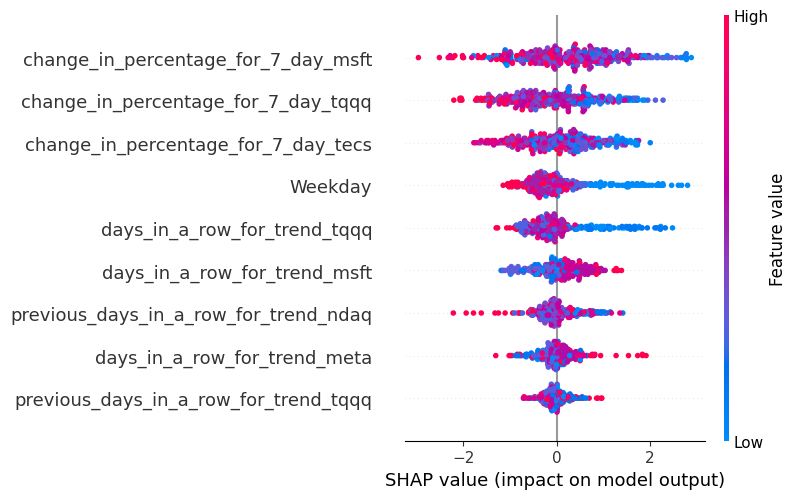

In [229]:
xgb = XGBClassifier(verbosity=0)  # Choose XGBoost model
xgb.fit(data_lst[-1][0], data_lst[-1][2])  # fit the model with the train data
explainer = shap.TreeExplainer(xgb)  # Create object that can calculate shap values
# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(data_lst[-1][0])
# create the summary plot on the data
shap.summary_plot(shap_values, data_lst[-1][0], max_display=30)

In [231]:
shap.force_plot(
    explainer.expected_value, shap_values[-1, :], data_lst[-1][0].iloc[-1, :]
)

In [232]:
# apply the local interpretation for the first random row
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[-1, :], data_lst[-1][1])

# More details about the model performances

In [233]:
def print_details_for_df(df, is_positive_df):
    n = len(df)
    if is_positive_df:
        direction = "positive"
        true_predicted_days = df[df["Model_daily_change"] > 0]
        true_n_predicted = len(true_predicted_days)
        avg_market = df["tqqq actual change"].mean()
        avg_model = df["Model_daily_change"].mean()
    else:
        direction = "negative"
        true_predicted_days = df[df["Model_daily_change"] > 0]
        true_n_predicted = len(true_predicted_days)
        avg_market = df["tqqq actual change"].mean()
        avg_model = df["Model_daily_change"].mean()

    print("We had", n, direction, "days")
    print("Out of", n, direction, "days, the model predicted", true_n_predicted, "days")
    print(
        "The ratio of",
        direction,
        "days that the model caught is:",
        true_n_predicted / n,
    )
    print(
        "The average change of the tqqq was",
        avg_market,
        "and the average change of the model was",
        avg_model,
    )

In [234]:
positive_days = concat[concat["tqqq actual change"] > 0]
print_details_for_df(positive_days, 1)

We had 1490 positive days
Out of 1490 positive days, the model predicted 1268 days
The ratio of positive days that the model caught is: 0.851006711409396
The average change of the tqqq was 2.6530075520565792 and the average change of the model was 1.9718538194050999


In [235]:
negative_days = concat[concat["sqqq actual change"] > 0]
print_details_for_df(negative_days, 0)

We had 1166 negative days
Out of 1166 negative days, the model predicted 193 days
The ratio of negative days that the model caught is: 0.16552315608919382
The average change of the tqqq was -2.919836312038833 and the average change of the model was -1.990265091220146


# Final prediction

In [236]:
def final_split_data_into_train_test(
    all_data,
    features,
    label,
    column_for_real_money_check,
    column_for_real_money_check_2,
    positive_column_for_real_money_check_qqq,
):
    x = all_data[
        features
        + [column_for_real_money_check]
        + [column_for_real_money_check_2]
        + [positive_column_for_real_money_check_qqq]
    ]
    y = all_data[label]
    x = x.sort_index()
    y = y.sort_index()
    now = datetime.now()
    hour = now.hour
    if hour in [8, 9, 10, 11, 12, 13, 14, 15]:
        until_index = -29
        from_index = -389
    else:
        until_index = -30
        from_index = -390

    x_test = x.iloc[until_index:, :]

    y_test = y.iloc[until_index:, :]
    x_train = x.iloc[from_index:until_index, :]
    y_train = y.iloc[from_index:until_index, :]
    x_train = x_train.sort_index()
    y_train = y_train.sort_index()
    return x_train, x_test, y_train, y_test

In [237]:
def PreProccesing_train_for_final_prediction(
    columns_to_merge_after_normalized,
    columns_to_normalize,
    columns_for_x,
    column_for_y,
    column_for_real_money_check,
    column_for_real_money_check_2,
    positive_column_for_real_money_check_qqq,
    new_columns_for_x_temp,
    pca=False,
    adasyn=False,
    yf_df=False,
):
    merged_dfs = preproccesing_data(yf_df, 0)
    x_train_temp, x_test_temp, y_train, y_test = final_split_data_into_train_test(
        merged_dfs,
        columns_for_x,
        column_for_y,
        column_for_real_money_check,
        column_for_real_money_check_2,
        positive_column_for_real_money_check_qqq,
    )

    x_train = x_train_temp[columns_for_x]
    x_test = x_test_temp[columns_for_x]

    y_in_percentage_train = x_train_temp[
        column_for_real_money_check
    ]  # .reset_index(drop=True,inplace=True)
    y_in_percentage_test = x_test_temp[
        column_for_real_money_check
    ]  # .reset_index(drop=True,inplace=True)

    negative_y_in_percentage_train = x_train_temp[
        column_for_real_money_check_2
    ]  # .reset_index(drop=True,inplace=True)
    negative_y_in_percentage_test = x_test_temp[
        column_for_real_money_check_2
    ]  # .reset_index(drop=True,inplace=True)

    qqq_y_in_percentage_train = x_train_temp[
        positive_column_for_real_money_check_qqq
    ]  # .reset_index(drop=True,inplace=True)
    qqq_y_in_percentage_test = x_test_temp[
        positive_column_for_real_money_check_qqq
    ]  # .reset_index(drop=True,inplace=True)

    normal_data_train, standard_scaler = Normalize_minmax(x_train[columns_to_normalize])
    data_after_normalize_train = pd.concat(
        [x_train[columns_to_merge_after_normalized], normal_data_train], axis=1
    )
    x_train_after_normalize = data_after_normalize_train[columns_for_x]
    normal_data_test = Normalize_minmax(x_test[columns_to_normalize], standard_scaler)

    data_after_normalize_test = pd.concat(
        [x_test[columns_to_merge_after_normalized], normal_data_test], axis=1
    )

    x_test_after_normalize = data_after_normalize_test[columns_for_x]
    if adasyn:
        x_train_after_normalize, y_train = make_smote(x_train_after_normalize, y_train)

    x_train_after_normalize = x_train_after_normalize[new_columns_for_x_temp]
    x_test_after_normalize = x_test_after_normalize[new_columns_for_x_temp]
    if pca:

        data_after_pca_train, pca = pca_cols(x_train_after_normalize, 0.75)
        data_after_pca_test = pca_cols(x_test_after_normalize, 0.75, pca)
        return (
            data_after_pca_train,
            data_after_pca_test,
            y_train,
            y_test,
            y_in_percentage_train,
            y_in_percentage_test,
            qqq_y_in_percentage_train,
            qqq_y_in_percentage_test,
            standard_scaler,
            pca,
        )
    return (
        x_train_after_normalize,
        x_test_after_normalize,
        y_train,
        y_test,
        y_in_percentage_train,
        y_in_percentage_test,
        negative_y_in_percentage_train,
        negative_y_in_percentage_test,
        qqq_y_in_percentage_train,
        qqq_y_in_percentage_test,
        standard_scaler,
    )

In [192]:
(
    final_train_data_for_prediction,
    last_month_test_data,
    final_train_lables_for_prediction,
    last_month_label,
    final_y_in_percentage_train,
    final_y_in_percentage_last_month,
    final_negative_y_in_percentage_train,
    final_negative_y_in_percentage_last_month,
    qqq_y_in_percentage_train,
    qqq_y_in_percentage_test,
    final_standard_scaler,
) = PreProccesing_train_for_final_prediction(
    columns_to_merge_after_normalized,
    columns_to_normalize,
    columns_for_x,
    column_for_y,
    positive_column_for_real_money_check,
    negative_column_for_real_money_check,
    positive_column_for_real_money_check_qqq,
    new_columns_for_x_temp,
    pca=False,
    adasyn=False,
    yf_df=True,
)

yf
[*********************100%***********************]  14 of 14 completed


In [193]:
final_train_data_for_prediction

,change_in_percentage_for_7_day_msft,days_in_a_row_for_trend_msft,days_in_a_row_for_trend_fb,change_in_percentage_for_7_day_tqqq,days_in_a_row_for_trend_tqqq,previous_days_in_a_row_for_trend_tqqq,previous_days_in_a_row_for_trend_ndaq,change_in_percentage_for_7_day_tecs,Weekday
Date,,,,,,,,,
2020-08-10,0.711551,0.357143,0.583333,0.777179,0.294118,0.764706,0.250000,0.132523,0
2020-08-11,0.619792,0.285714,0.333333,0.715890,0.235294,0.764706,0.666667,0.169128,1
2020-08-12,0.484953,0.214286,0.250000,0.502102,0.176471,0.764706,0.666667,0.373070,2
2020-08-13,0.365275,0.500000,0.500000,0.568017,0.411765,0.176471,0.666667,0.381558,3
2020-08-14,0.422475,0.357143,0.583333,0.556847,0.470588,0.176471,0.666667,0.395526,4
...,...,...,...,...,...,...,...,...,...
2022-01-05,0.443421,0.142857,0.333333,0.509634,0.294118,0.411765,0.500000,0.398075,2
2022-01-06,0.171037,0.071429,0.250000,0.265594,0.235294,0.411765,0.500000,0.691838,3
2022-01-07,0.152264,0.000000,0.500000,0.280063,0.176471,0.411765,0.166667,0.687913,4


In [194]:
# final_train_data_for_prediction

In [195]:
last_month_test_data

,change_in_percentage_for_7_day_msft,days_in_a_row_for_trend_msft,days_in_a_row_for_trend_fb,change_in_percentage_for_7_day_tqqq,days_in_a_row_for_trend_tqqq,previous_days_in_a_row_for_trend_tqqq,previous_days_in_a_row_for_trend_ndaq,change_in_percentage_for_7_day_tecs,Weekday
Date,,,,,,,,,
2022-01-12,0.229405,0.642857,0.500000,0.350693,0.470588,0.117647,0.250000,0.609345,2
2022-01-13,0.294883,0.714286,0.333333,0.322340,0.529412,0.117647,0.250000,0.634183,3
2022-01-14,0.182748,0.357143,0.250000,0.264751,0.294118,0.529412,0.583333,0.721789,4
2022-01-18,0.431622,0.500000,0.500000,0.451626,0.411765,0.294118,0.583333,0.498956,1
2022-01-19,0.356825,0.357143,0.333333,0.328489,0.294118,0.411765,0.583333,0.605937,2
2022-01-20,0.364533,0.500000,0.500000,0.324928,0.235294,0.411765,0.583333,0.628027,3
2022-01-21,0.335932,0.357143,0.333333,0.255518,0.176471,0.411765,0.583333,0.709290,4
2022-01-24,0.244548,0.285714,0.250000,0.062126,0.117647,0.411765,0.583333,0.905585,0
2022-01-25,0.204734,0.500000,0.500000,0.066328,0.411765,0.117647,0.583333,0.906457,1


In [196]:
# starting_money = 100
# threshold = 0.15
# clf = XGB_clf
# end_money,change_in_ratio,short_indexes,long_indexes,commission, money_list, just_long_list, just_long_list_qqq, y_proba = calculate_how_much_money_i_will_have(starting_money,threshold,clf,final_train_data_for_prediction, last_month_test_data, final_train_lables_for_prediction, final_y_in_percentage_last_month,final_negative_y_in_percentage_last_month,qqq_y_in_percentage_test, with_short=True)
# print('len of short list is:',len(short_indexes))
# print('len of long list is:',len(long_indexes))
# print(change_in_ratio)
# print(just_long_list[-1]/just_long_list[0])
# print(just_long_list_qqq[-1]/just_long_list_qqq[0])

In [197]:
# plot_lineplot(list(final_y_in_percentage_last_month.index), money_list, just_long_list,just_long_list_qqq)

In [198]:
# create_a_comparing_table( starting_money, money_list, just_long_list,just_long_list_qqq, last_month_test_data.index)

In [199]:
# show_y_proba_with_change_in_stocks(final_y_in_percentage_last_month,final_negative_y_in_percentage_last_month,y_proba)

In [200]:
# XGB_clf.fit(final_train_data_for_prediction,final_train_lables_for_prediction)                                                     # Fit the model
# y_proba = XGB_clf.predict_proba(last_month_test_data)
# y_proba = [v[1] for v in y_proba]

# predict_train = [x>0.15 for x in y_proba]
# cm=confusion_matrix(last_month_label[column_for_y[0]],predict_train)                                   # Create a confusion matrix object
# tn, fp, fn, tp=cm.ravel()                                                    # Make the matrix in the right order that we know
# cm_update=np.array([[tp,fp],[fn,tn]])                                        # Save the good matrix


# # Plot the confusion matrix (with heat map)

# sns.heatmap(cm_update, cmap="Blues", annot=True,fmt="d",cbar=False,linewidth=0.3,xticklabels=['1','0'], yticklabels=['1','0'])
# plt.xlabel('Actual')                                                          # Add title to x-axis
# plt.ylabel('Predict')                                                         # Add title to y-axis
# plt.title('Confusion matrix for the Logistic Regression classifier')          # Add title to the plot
# b, t = plt.ylim()                                                             # discover the values for bottom and top
# b += 0.5                                                                      # Add 0.5 to the bottom
# t -= 0.5                                                                      # Subtract 0.5 from the top
# plt.ylim(b, t)                                                                # update the ylim(bottom, top) valu
# plt.show()

# print ('\nNow we will present some measures we learned:')                     # Show measures that we learnes
# print ('-The accuracy is:   ',accuracy_score(last_month_label,predict_train))
# print ('-The recall is:     ',recall_score(last_month_label,predict_train))
# print ('-The precision is:  ',precision_score(last_month_label,predict_train))
# print ('-The specificity is:',str(tn/(tn+fp)))
# print ('-The FPR is:        ',str(fp/(tn+fp)))

In [201]:
now = datetime.now()
hour = now.hour
minute = now.minute
if hour in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    before_midnight = False
else:
    before_midnight = True

In [202]:
print(now)

2022-03-10 10:25:20.042436


In [203]:
def organized_data_for_prediction(before_midnight, yf_df=False):
    now = datetime.now()
    if not yf_df:
        result = load_data()
        info = result[1:]
        columns = result[0]
        df = pd.DataFrame(info, columns=columns)
        df.loc[len(df)] = 0
        df.loc[len(df) - 1]["Date"] = str(
            datetime.today().strftime("%d/%m/%Y 16:00:00")
        )
        tqqq_df = df.iloc[:, [35, 36]]
        sqqq_df = df.iloc[:, [38, 39]]
        uvxy_df = df.iloc[:, [41, 42]]

    else:
        df = create_yf_df()
        print("create yf_df took", (datetime.now() - now))
        now = datetime.now()
        new_row = [0] * df.shape[1]
        date_indexes_lst = []
        for i in range(len(df.columns)):
            if df.columns[i] == "Date":
                date_indexes_lst.append(i)
        for j in date_indexes_lst:
            if not before_midnight:
                if (datetime.today().weekday()) not in [5, 6]:
                    new_row[j] = pd.to_datetime(
                        datetime.today().strftime("%Y-%m-%d 00:00:00")
                    )
                elif (datetime.today().weekday()) == 5:
                    new_row[j] = pd.to_datetime(
                        (datetime.today() + timedelta(days=2)).strftime(
                            "%Y-%m-%d 00:00:00"
                        )
                    )
                else:
                    new_row[j] = pd.to_datetime(
                        (datetime.today() + timedelta(days=1)).strftime(
                            "%Y-%m-%d 00:00:00"
                        )
                    )
            else:
                if (datetime.today().weekday()) not in [4, 5]:
                    new_row[j] = pd.to_datetime(
                        (datetime.today() + timedelta(days=1)).strftime(
                            "%Y-%m-%d 00:00:00"
                        )
                    )
                elif (datetime.today().weekday()) == 4:
                    new_row[j] = pd.to_datetime(
                        (datetime.today() + timedelta(days=3)).strftime(
                            "%Y-%m-%d 00:00:00"
                        )
                    )
                else:
                    new_row[j] = pd.to_datetime(
                        (datetime.today() + timedelta(days=2)).strftime(
                            "%Y-%m-%d 00:00:00"
                        )
                    )
        print("add todays row took", (datetime.now() - now))
        now = datetime.now()
        df.loc[len(df)] = new_row

        tqqq_df = df.iloc[:, [34, 35]]
        sqqq_df = df.iloc[:, [37, 38]]
        uvxy_df = df.iloc[:, [40, 41]]

    # Creating a DataFrame for each stock:
    amzn_df = df.iloc[:, [1, 2, 4]]
    tsla_df = df.iloc[:, [6, 7, 9]]
    msft_df = df.iloc[:, [11, 12, 14]]
    meta_df = df.iloc[:, [16, 17, 19]]
    googl_df = df.iloc[:, [21, 22, 24]]
    aapl_df = df.iloc[:, [26, 27, 29]]
    bac_df = df.iloc[:, [43, 44, 46]]
    ndaq_df = df.iloc[:, [48, 49, 51]]
    tecs_df = df.iloc[:, [53, 54, 56]]
    qqq_df = df.iloc[:, [58, 59]]

    spy_df = df.iloc[:, [31, 32]]
    #     US_treasury_rate_10_years = df.iloc[:,28]
    dfs = [
        amzn_df,
        tsla_df,
        msft_df,
        meta_df,
        googl_df,
        aapl_df,
        spy_df,
        tqqq_df,
        sqqq_df,
        uvxy_df,
        bac_df,
        ndaq_df,
        tecs_df,
        qqq_df,
    ]
    dfs_names = [
        "amzn",
        "tsla",
        "msft",
        "meta",
        "googl",
        "aapl",
        "spy",
        "tqqq",
        "sqqq",
        "uvxy",
        "bac",
        "ndaq",
        "tecs",
        "qqq",
    ]
    if not yf_df:
        change_date_for_df(dfs)
    print("arranging the dfs took", (datetime.now() - now))
    now = datetime.now()
    calculate_change_in_percentage_for_dfs(dfs, dfs_names)
    print("calculate_change_in_percentage_for_dfs took", (datetime.now() - now))
    now = datetime.now()
    calculate_average_volume_for_dfs(dfs, dfs_names)
    print("calculate_average_volume_for_dfs took", (datetime.now() - now))
    now = datetime.now()
    calculate_average_close_price_for_dfs(dfs, dfs_names)
    print("calculate_average_close_price_for_dfs took", (datetime.now() - now))
    now = datetime.now()

    add_label_x_days_before_to_qqq_df(tqqq_df)
    print("add_label_x_days_before_to_qqq_df took", (datetime.now() - now))
    now = datetime.now()
    add_label_x_days_to_the_future_to_qqq_df(tqqq_df)
    print("add_label_x_days_to_the_future_to_qqq_df took", (datetime.now() - now))
    now = datetime.now()
    add_change_for_x_days_to_the_future(tqqq_df)
    print("add_change_for_x_days_to_the_future took", (datetime.now() - now))
    now = datetime.now()

    add_change_for_x_days_to_the_future(sqqq_df, 1)
    print("add_change_for_x_days_to_the_future took", (datetime.now() - now))
    now = datetime.now()
    add_label_x_days_before_to_qqq_df(sqqq_df, 1)
    print("add_label_x_days_before_to_qqq_df took", (datetime.now() - now))
    now = datetime.now()

    add_label_x_days_before_to_qqq_df(qqq_df, 2)
    print("add_label_x_days_before_to_qqq_df took", (datetime.now() - now))
    now = datetime.now()
    add_change_for_x_days_to_the_future(qqq_df, 2)
    print("add_change_for_x_days_to_the_future took", (datetime.now() - now))
    now = datetime.now()

    calculate_trend_for_dfs(dfs, dfs_names)
    print("calculate_trend_for_dfs took", (datetime.now() - now))
    now = datetime.now()
    add_previous_trend_for_dfs(dfs, dfs_names)
    print("add_previous_trend_for_dfs took", (datetime.now() - now))
    now = datetime.now()

    highest_prices_dict = calculate_highest_prices_dict(dfs, dfs_names)
    print("highest_prices_dict took", (datetime.now() - now))
    now = datetime.now()

    add_a_break_record_column_for_dfs(dfs, highest_prices_dict, dfs_names)

    print("add_a_break_record_column_for_dfs took", (datetime.now() - now))
    now = datetime.now()

    merged_dfs = merge_dfs(dfs)
    print("merged_dfs took", (datetime.now() - now))
    now = datetime.now()

    merged_dfs = merged_dfs.drop(["Volume", "Close"], axis=1)
    merged_dfs["After Covid"] = merged_dfs["Date"].apply(after_covid)
    #     merged_dfs = pd.concat([merged_dfs,US_treasury_rate_10_years],axis=1)
    merged_dfs["Weekday"] = merged_dfs["Date"].dt.dayofweek

    merged_dfs = merged_dfs.set_index("Date").sort_index()
    print("merged_dfs indexes took", (datetime.now() - now))
    now = datetime.now()
    #     new_row = pd.DataFrame([[datetime.today().strftime("%Y-%m-%d")]],columns = ['Date','Close','Volume'])

    #     merged_dfs['10 Years US Treasury Yield Curve Rates'] = merged_dfs['10 Years US Treasury Yield Curve Rates'].astype(float)
    return (
        amzn_df,
        tsla_df,
        msft_df,
        meta_df,
        googl_df,
        aapl_df,
        spy_df,
        tqqq_df,
        sqqq_df,
        uvxy_df,
        highest_prices_dict,
        merged_dfs,
    )


def predict_today(
    df,
    columns_for_x,
    column_for_real_money_check,
    column_for_real_money_check2,
    positive_column_for_real_money_check_qqq,
    standard_scaler,
    columns_to_normalize,
    columns_to_merge_after_normalized,
    new_columns_for_x_temp,
    pca=False,
):
    x_test = df[columns_for_x]
    y_in_percentage_test = df[
        column_for_real_money_check
    ]  # .reset_index(drop=True,inplace=True)
    negative_y_in_percentage_test = df[
        column_for_real_money_check2
    ]  # .reset_index(drop=True,inplace=True)
    qqq_y_in_percentage_test = df[positive_column_for_real_money_check_qqq]

    normal_data_test = Normalize_minmax(x_test[columns_to_normalize], standard_scaler)
    data_after_normalize_test = pd.concat(
        [x_test[columns_to_merge_after_normalized], normal_data_test], axis=1
    )
    x_test_after_normalize = data_after_normalize_test[columns_for_x]

    x_test_after_normalize = x_test_after_normalize[new_columns_for_x_temp]
    if pca:
        data_after_pca_test = pca_cols(x_test_after_normalize, 0.75, pca)
        return (
            data_after_pca_test,
            y_in_percentage_test,
            negative_y_in_percentage_test,
            qqq_y_in_percentage_test,
        )
    return (
        x_test_after_normalize,
        y_in_percentage_test,
        negative_y_in_percentage_test,
        qqq_y_in_percentage_test,
    )

In [204]:
(
    amzn_df,
    tsla_df,
    msft_df,
    meta_df,
    googl_df,
    aapl_df,
    spy_df,
    tqqq_df,
    sqqq_df,
    uvxy_df,
    highest_prices_dict,
    merged_dfs,
) = organized_data_for_prediction(before_midnight, yf_df=True)

[*********************100%***********************]  14 of 14 completed
create yf_df took 0:00:01.228678
add todays row took 0:00:00.004986
arranging the dfs took 0:00:00.030949
calculate_change_in_percentage_for_dfs took 0:00:37.980474
calculate_average_volume_for_dfs took 0:00:18.194650
calculate_average_close_price_for_dfs took 0:00:27.277660
add_label_x_days_before_to_qqq_df took 0:00:03.940539
add_label_x_days_to_the_future_to_qqq_df took 0:00:02.573676
add_change_for_x_days_to_the_future took 0:00:02.535990
add_change_for_x_days_to_the_future took 0:00:02.802214
add_label_x_days_before_to_qqq_df took 0:00:03.411999
add_label_x_days_before_to_qqq_df took 0:00:03.634854
add_change_for_x_days_to_the_future took 0:00:02.533249
calculate_trend_for_dfs took 0:00:51.087940
add_previous_trend_for_dfs took 0:00:01.489015
highest_prices_dict took 0:00:08.442413
add_a_break_record_column_for_dfs took 0:00:00.603418
merged_dfs took 0:00:00.028891
merged_dfs indexes took 0:00:00.243347


In [205]:
def update_merge_df(previous_merge, before_midnight, yf_df=False):
    now = datetime.now()
    if not yf_df:
        result = load_data()
        info = result[1:]
        columns = result[0]
        df = pd.DataFrame(info, columns=columns)
        df.loc[len(df)] = 0
        df.loc[len(df) - 1]["Date"] = str(
            datetime.today().strftime("%d/%m/%Y 16:00:00")
        )
        tqqq_df = df.iloc[:, [35, 36]]
        sqqq_df = df.iloc[:, [38, 39]]
        uvxy_df = df.iloc[:, [41, 42]]

    else:
        df = create_yf_df()
        df = df.iloc[-10:, :].reset_index(drop=True)

        #         print('create yf_df took',(datetime.now()-now))
        now = datetime.now()
        new_row = [0] * df.shape[1]
        date_indexes_lst = []
        for i in range(len(df.columns)):
            if df.columns[i] == "Date":
                date_indexes_lst.append(i)
        for j in date_indexes_lst:
            if not before_midnight:
                if (datetime.today().weekday()) not in [5, 6]:
                    new_row[j] = pd.to_datetime(
                        datetime.today().strftime("%Y-%m-%d 00:00:00")
                    )
                elif (datetime.today().weekday()) == 5:
                    new_row[j] = pd.to_datetime(
                        (datetime.today() + timedelta(days=2)).strftime(
                            "%Y-%m-%d 00:00:00"
                        )
                    )
                else:
                    new_row[j] = pd.to_datetime(
                        (datetime.today() + timedelta(days=1)).strftime(
                            "%Y-%m-%d 00:00:00"
                        )
                    )
            else:
                if (datetime.today().weekday()) not in [4, 5]:
                    new_row[j] = pd.to_datetime(
                        (datetime.today() + timedelta(days=1)).strftime(
                            "%Y-%m-%d 00:00:00"
                        )
                    )
                elif (datetime.today().weekday()) == 4:
                    new_row[j] = pd.to_datetime(
                        (datetime.today() + timedelta(days=3)).strftime(
                            "%Y-%m-%d 00:00:00"
                        )
                    )
                else:
                    new_row[j] = pd.to_datetime(
                        (datetime.today() + timedelta(days=2)).strftime(
                            "%Y-%m-%d 00:00:00"
                        )
                    )
        #         print( 'add todays row took',(datetime.now()-now))
        now = datetime.now()
        df.loc[len(df)] = new_row
        tqqq_df = df.iloc[:, [34, 35]]
        sqqq_df = df.iloc[:, [37, 38]]
        uvxy_df = df.iloc[:, [40, 41]]

    # Creating a DataFrame for each stock:
    amzn_df = df.iloc[:, [1, 2, 4]]
    tsla_df = df.iloc[:, [6, 7, 9]]
    msft_df = df.iloc[:, [11, 12, 14]]
    meta_df = df.iloc[:, [16, 17, 19]]
    googl_df = df.iloc[:, [21, 22, 24]]
    aapl_df = df.iloc[:, [26, 27, 29]]
    bac_df = df.iloc[:, [43, 44, 46]]
    ndaq_df = df.iloc[:, [48, 49, 51]]
    tecs_df = df.iloc[:, [53, 54, 56]]
    qqq_df = df.iloc[:, [58, 59]]

    spy_df = df.iloc[:, [31, 32]]
    #     US_treasury_rate_10_years = df.iloc[:,28]
    dfs = [
        amzn_df,
        tsla_df,
        msft_df,
        meta_df,
        googl_df,
        aapl_df,
        spy_df,
        tqqq_df,
        sqqq_df,
        uvxy_df,
        bac_df,
        ndaq_df,
        tecs_df,
        qqq_df,
    ]
    dfs_names = [
        "amzn",
        "tsla",
        "msft",
        "meta",
        "googl",
        "aapl",
        "spy",
        "tqqq",
        "sqqq",
        "uvxy",
        "bac",
        "ndaq",
        "tecs",
        "qqq",
    ]
    if not yf_df:
        change_date_for_df(dfs)
    #     print( 'arranging the dfs took',(datetime.now()-now))
    now = datetime.now()
    calculate_change_in_percentage_for_dfs(dfs, dfs_names)
    #     print( 'calculate_change_in_percentage_for_dfs took',(datetime.now()-now))
    now = datetime.now()
    calculate_average_volume_for_dfs(dfs, dfs_names)
    #     print( 'calculate_average_volume_for_dfs took',(datetime.now()-now))
    now = datetime.now()
    calculate_average_close_price_for_dfs(dfs, dfs_names)
    #     print( 'calculate_average_close_price_for_dfs took',(datetime.now()-now))
    now = datetime.now()

    add_label_x_days_before_to_qqq_df(tqqq_df)
    #     print( 'add_label_x_days_before_to_qqq_df took',(datetime.now()-now))
    now = datetime.now()
    add_label_x_days_to_the_future_to_qqq_df(tqqq_df)
    #     print( 'add_label_x_days_to_the_future_to_qqq_df took',(datetime.now()-now))
    now = datetime.now()
    add_change_for_x_days_to_the_future(tqqq_df)
    #     print( 'add_change_for_x_days_to_the_future took',(datetime.now()-now))
    now = datetime.now()

    add_change_for_x_days_to_the_future(sqqq_df, 1)
    #     print( 'add_change_for_x_days_to_the_future took',(datetime.now()-now))
    now = datetime.now()
    add_label_x_days_before_to_qqq_df(sqqq_df, 1)
    #     print( 'add_label_x_days_before_to_qqq_df took',(datetime.now()-now))
    now = datetime.now()

    add_label_x_days_before_to_qqq_df(qqq_df, 2)
    #     print( 'add_label_x_days_before_to_qqq_df took',(datetime.now()-now))
    now = datetime.now()
    add_change_for_x_days_to_the_future(qqq_df, 2)
    #     print( 'add_change_for_x_days_to_the_future took',(datetime.now()-now))
    now = datetime.now()

    calculate_trend_for_dfs(dfs, dfs_names)
    #     print( 'calculate_trend_for_dfs took',(datetime.now()-now))
    now = datetime.now()
    add_previous_trend_for_dfs(dfs, dfs_names)
    #     print( 'add_previous_trend_for_dfs took',(datetime.now()-now))
    now = datetime.now()

    highest_prices_dict = calculate_highest_prices_dict(dfs, dfs_names)
    #     print( 'highest_prices_dict took',(datetime.now()-now))
    now = datetime.now()

    add_a_break_record_column_for_dfs(dfs, highest_prices_dict, dfs_names)

    #     print( 'add_a_break_record_column_for_dfs took',(datetime.now()-now))
    now = datetime.now()

    merged_dfs = merge_dfs(dfs)
    #     print( 'merged_dfs took',(datetime.now()-now))
    now = datetime.now()

    merged_dfs = merged_dfs.drop(["Volume", "Close"], axis=1)
    merged_dfs["After Covid"] = merged_dfs["Date"].apply(after_covid)
    #     merged_dfs = pd.concat([merged_dfs,US_treasury_rate_10_years],axis=1)
    merged_dfs["Weekday"] = merged_dfs["Date"].dt.dayofweek

    merged_dfs = merged_dfs.set_index("Date").sort_index()
    #     print( 'merged_dfs indexes took',(datetime.now()-now))
    now = datetime.now()
    new_merge = previous_merge.copy()
    new_merge.iloc[-1, :] = merged_dfs.iloc[-1, :]
    #     new_row = pd.DataFrame([[datetime.today().strftime("%Y-%m-%d")]],columns = ['Date','Close','Volume'])

    #     merged_dfs['10 Years US Treasury Yield Curve Rates'] = merged_dfs['10 Years US Treasury Yield Curve Rates'].astype(float)
    return pd.DataFrame(new_merge)

In [206]:
def send_proba(clf, train_data, test_row, train_labels, threshold):
    clf.fit(train_data, train_labels)  # Fit the model
    y_proba = clf.predict_proba(test_row)
    y_proba = y_proba[0][1]
    if y_proba > threshold:
        print(y_proba, "buy")
        return y_proba, "buy"
    else:
        print(y_proba, "sell")
        return y_proba, "sell"

In [207]:
def predict_todays_direction(
    clf,
    train_data,
    train_labels,
    threshold,
    previous_merge,
    columns_for_x,
    positive_column_for_real_money_check,
    negative_column_for_real_money_check,
    positive_column_for_real_money_check_qqq,
    final_standard_scaler,
    columns_to_normalize,
    columns_to_merge_after_normalized,
    new_columns_for_x_temp,
    no_trading_dates=["2021-09-06", "2021-11-25", "2021-12-24"],
):
    now = datetime.now()
    hour = now.hour
    minute = now.minute
    if hour in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
        before_midnight = False
    else:
        before_midnight = True
    merged_dfs_new = update_merge_df(previous_merge, before_midnight, yf_df=True)
    x_test, y_test, negative_y_test, qqq_y_test = predict_today(
        merged_dfs_new,
        columns_for_x,
        positive_column_for_real_money_check,
        negative_column_for_real_money_check,
        positive_column_for_real_money_check_qqq,
        final_standard_scaler,
        columns_to_normalize,
        columns_to_merge_after_normalized,
        new_columns_for_x_temp,
        pca=False,
    )

    todays_row = pd.DataFrame(x_test.iloc[-1]).T

    while True:
        if todays_row.index in no_trading_dates:
            todays_row.index = todays_row.index + timedelta(days=1)
            todays_row["Weekday"] += 1
            if list(todays_row["Weekday"])[0] == 5:
                todays_row.index = todays_row.index + timedelta(days=2)
                todays_row["Weekday"] = 0
            elif list(todays_row["Weekday"])[0] == 6:
                todays_row.index = todays_row.index + timedelta(days=1)
                todays_row["Weekday"] = 0
        else:
            break
    todays_row = todays_row.fillna(0)
    proba, action = send_proba(clf, train_data, todays_row, train_labels, threshold)
    return proba, action, todays_row

In [208]:
proba, action, todays_row = predict_todays_direction(
    XGB_clf,
    final_train_data_for_prediction,
    final_train_lables_for_prediction,
    0.15,
    merged_dfs,
    columns_for_x,
    positive_column_for_real_money_check,
    negative_column_for_real_money_check,
    positive_column_for_real_money_check_qqq,
    final_standard_scaler,
    columns_to_normalize,
    columns_to_merge_after_normalized,
    new_columns_for_x_temp,
    no_trading_dates=[
        "2021-09-06",
        "2021-11-25",
        "2021-12-24",
        "2022-01-17",
        "2022-02-21",
        "2022-04-15",
        "2022-05-30",
        "2022-06-20",
        "2022-07-04",
        "2022-09-05",
        "2022-11-24",
        "2022-12-26",
    ],
)

[*********************100%***********************]  14 of 14 completed
0.13390446 sell


In [209]:
todays_row

,change_in_percentage_for_7_day_msft,days_in_a_row_for_trend_msft,days_in_a_row_for_trend_fb,change_in_percentage_for_7_day_tqqq,days_in_a_row_for_trend_tqqq,previous_days_in_a_row_for_trend_tqqq,previous_days_in_a_row_for_trend_ndaq,change_in_percentage_for_7_day_tecs,Weekday
2022-03-10,0.362991,0.5,0.583333,0.316582,0.411765,0.117647,0.166667,0.555653,3.0



# Save my predictions to csv fle:

In [210]:
# row_str = str(datetime.today().strftime("%Y-%m-%d"))+' , '+str(proba) + ' , ' + str(action)
# row_lst = [datetime.today().strftime("%Y-%m-%d"), proba, action,np.nan]

In [211]:
# #Add todays prediction and update yesterdays resuld
# csv_df = pd.read_csv('records.csv')
# if csv_df['Action'][len(csv_df)-1]=='buy':
#     csv_df['actual_change'][len(csv_df)-1] = last_month_label[csv_df.iloc[-1]['Date']]
# else:
#     csv_df['actual_change'][len(csv_df)-1] = negative_last_month_label[csv_df.iloc[-1]['Date']]
# csv_df = csv_df.append(pd.DataFrame(row_lst).T.rename(columns = {0:'Date',1:'Probability to a positive day',2:'Action',3:'actual_change'}))
# csv_df.to_csv('records.csv',index=False)

# 2D and 3D visuals of the data after PCA

In [212]:
# def pca_n_componnents (relevant_data,n_components,pca=False):
#     if not pca:
#         pca_num=PCA(n_components=relevant_data.shape[1])                # Initialize PCA object
#         pca_num=pca_num.fit(relevant_data)                              # Fit the model with the data
#         pca_exp=pca_num.explained_variance_ratio_                       # Percentage of variance explained by each of the selected components

#         print ('\n\nFor visualization this is the cumulative explained variance plot for each numeric column')
#         plt.plot(np.cumsum(pca_exp), color='blueviolet')               # Plot for visualozation- the number of components vs cumulative explained variance
#         plt.xlabel('number of components')                             # Add title for x-axis
#         plt.ylabel('cumulative explained variance')                    # Add title for y-axis
#         plt.grid()                                                     # Add grid for the plot
#         plt.show()                                                     # show the plot

#         pca=PCA(n_components = n_components)                                             # Initialize PCA object that will explain the threshold
#         pca=pca.fit(relevant_data)                                     # Fit the model with the data
#         pca_explain=pca.explained_variance_ratio_                      # Percentage of variance explained by each of the selected components
#         print ('\nThe cumulative explained variance for this pca action is:',sum(pca_explain))
#         data_after_pca=pd.DataFrame(pca.transform(relevant_data),index=relevant_data.index)      # Apply the PCA on the train data
#         return data_after_pca,pca
#     else:
#         data_after_pca=pd.DataFrame(pca.transform(relevant_data),index=relevant_data.index)      # Apply the PCA on the test data
#         return data_after_pca

In [213]:
# def PreProccesing(columns_to_merge_after_normalized,columns_to_normalize,columns_for_x,column_for_y,column_for_real_money_check,column_for_real_money_check_2, positive_column_for_real_money_check_qqq, new_columns_for_x_temp, pca=False,adasyn=False,yf_df=False):
#     merged_dfs=preproccesing_data(yf_df)
#     x_train_temp, x_test_temp, y_train, y_test = final_split_data_into_train_test(merged_dfs,columns_for_x, column_for_y,column_for_real_money_check,column_for_real_money_check_2, positive_column_for_real_money_check_qqq )
#     x_train = x_train_temp[columns_for_x]

#     x_test = x_test_temp[columns_for_x]

#     y_in_percentage_train = x_train_temp[column_for_real_money_check]#.reset_index(drop=True,inplace=True)
#     y_in_percentage_test = x_test_temp[column_for_real_money_check]#.reset_index(drop=True,inplace=True)

#     negative_y_in_percentage_train = x_train_temp[column_for_real_money_check_2]#.reset_index(drop=True,inplace=True)
#     negative_y_in_percentage_test = x_test_temp[column_for_real_money_check_2]#.reset_index(drop=True,inplace=True)

#     qqq_y_in_percentage_train = x_train_temp[positive_column_for_real_money_check_qqq]#.reset_index(drop=True,inplace=True)
#     qqq_y_in_percentage_test = x_test_temp[positive_column_for_real_money_check_qqq]#.reset_index(drop=True,inplace=True)

#     normal_data_train,standard_scaler = Normalize_minmax(x_train[columns_to_normalize])
#     data_after_normalize_train = pd.concat([x_train[columns_to_merge_after_normalized],normal_data_train],axis=1)
#     x_train_after_normalize = data_after_normalize_train[columns_for_x]
#     normal_data_test = Normalize_minmax(x_test[columns_to_normalize],standard_scaler)

#     data_after_normalize_test = pd.concat([x_test[columns_to_merge_after_normalized],normal_data_test],axis=1)

#     x_test_after_normalize = data_after_normalize_test[columns_for_x]
#     if adasyn:
#         x_train_after_normalize,y_train=make_smote(x_train_after_normalize,y_train)
# #     x_train_after_normalize = x_train_after_normalize[new_columns_for_x_temp]
# #     x_test_after_normalize = x_test_after_normalize[new_columns_for_x_temp]
#     if pca:


#         data_after_pca_train,pca = pca_n_componnents (x_train_after_normalize,2)
#         data_after_pca_test = pca_n_componnents (x_test_after_normalize,2,pca)
#         return data_after_pca_train,data_after_pca_test,\
#     y_train , y_test, y_in_percentage_train , y_in_percentage_test,\
#     negative_y_in_percentage_train, negative_y_in_percentage_test,\
#     qqq_y_in_percentage_train,qqq_y_in_percentage_test,standard_scaler,pca
#     return x_train_after_normalize,x_test_after_normalize,\
# y_train , y_test, y_in_percentage_train , y_in_percentage_test,\
# negative_y_in_percentage_train, negative_y_in_percentage_test,\
# qqq_y_in_percentage_train,qqq_y_in_percentage_test,standard_scaler

In [214]:
# final_train_data_2d, test_data_2d, train_lables_2d, test_label_2d, y_in_percentage_train_2d, y_in_percentage_test_2d,negative_y_in_percentage_train_2d, negative_y_in_percentage_test_2d,qqq_y_in_percentage_train_2d,qqq_y_in_percentage_test_2d,standard_scaler_2d,pca_2d= PreProccesing(columns_to_merge_after_normalized,columns_to_normalize,columns_for_x,column_for_y,positive_column_for_real_money_check,negative_column_for_real_money_check,positive_column_for_real_money_check_qqq, new_columns_for_x_temp,pca=True,adasyn=False,yf_df=True)

In [215]:
# # plot the 2 pc we got after the transformation- Projection of the data onto the first 2 PCs
# colors = ['green','red']
# plt.scatter(final_train_data_2d[0],final_train_data_2d[1],c = list(train_lables_2d['label_1_day']), cmap = matplotlib.colors.ListedColormap(colors), label='2D projected data\nfor first 2 PCs')   # plot the scaterr
# plt.quiver([0,0],[1,0],color='blue',width=.01, label='PC2') # add the arrows for the axises
# plt.quiver([1,0],[0,0],color='red',width=.01, label='PC1')
# plt.xlabel('PC1')                                           # add labels
# plt.ylabel('PC2')
# plt.title('the two-dimensional PC plot')                    # add title
# plt.legend()
# plt.show()

In [216]:
# smote = True
# if not smote:
#     # Plot of the reduced train data in 3D and each label with differents colors.
#     # in black points is the projected test data .
#     fig = plt.figure(figsize=(8,6))
#     ax = Axes3D(fig)
#     colors = ['red','green']
#     # plot the sactter for the train data in 3D- onto the first 3 Pcs
#     scat = ax.scatter(final_train_data_2d[0],final_train_data_2d[1],y_in_percentage_train_2d, c = list(train_lables_2d['label_1_day']), cmap=matplotlib.colors.ListedColormap(colors))
#     # plot the scatter for the projected test data
#     # ax.scatter(test_data_3d[0],test_data_3d[1],test_data_3d[2], c = list(test_label_3d['label_1_day']), label='the projected\ntest data')
#     # add lables
#     ax.set_xlabel('PC1')
#     ax.set_ylabel('PC2')
#     ax.set_zlabel('Y')
#     # add title
#     plt.title('3D- the reduced train data by each lable & the projected test data')

#     # add legend
#     N = 2
#     # define the colormap
#     cmap = plt.cm.jet
#     # extract all colors from the .jet map
#     cmaplist = [cmap(i) for i in range(cmap.N)]
#     # create the new map
#     cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
#     bounds = np.linspace(0,N,N+1)
#     norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
#     # create the colorbar
#     cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
#     cb.set_label('lables by colors on train data')
#     plt.legend()

#     plt.show()

In [217]:
# def PreProccesing(columns_to_merge_after_normalized,columns_to_normalize,columns_for_x,column_for_y,column_for_real_money_check,column_for_real_money_check_2, positive_column_for_real_money_check_qqq, new_columns_for_x_temp, pca=False,adasyn=False,yf_df=False):
#     merged_dfs=preproccesing_data(yf_df)
#     x_train_temp, x_test_temp, y_train, y_test = final_split_data_into_train_test(merged_dfs,columns_for_x, column_for_y,column_for_real_money_check,column_for_real_money_check_2, positive_column_for_real_money_check_qqq )
#     x_train = x_train_temp[columns_for_x]

#     x_test = x_test_temp[columns_for_x]

#     y_in_percentage_train = x_train_temp[column_for_real_money_check]#.reset_index(drop=True,inplace=True)
#     y_in_percentage_test = x_test_temp[column_for_real_money_check]#.reset_index(drop=True,inplace=True)

#     negative_y_in_percentage_train = x_train_temp[column_for_real_money_check_2]#.reset_index(drop=True,inplace=True)
#     negative_y_in_percentage_test = x_test_temp[column_for_real_money_check_2]#.reset_index(drop=True,inplace=True)

#     qqq_y_in_percentage_train = x_train_temp[positive_column_for_real_money_check_qqq]#.reset_index(drop=True,inplace=True)
#     qqq_y_in_percentage_test = x_test_temp[positive_column_for_real_money_check_qqq]#.reset_index(drop=True,inplace=True)

#     normal_data_train,standard_scaler = Normalize_minmax(x_train[columns_to_normalize])
#     data_after_normalize_train = pd.concat([x_train[columns_to_merge_after_normalized],normal_data_train],axis=1)
#     x_train_after_normalize = data_after_normalize_train[columns_for_x]
#     normal_data_test = Normalize_minmax(x_test[columns_to_normalize],standard_scaler)

#     data_after_normalize_test = pd.concat([x_test[columns_to_merge_after_normalized],normal_data_test],axis=1)

#     x_test_after_normalize = data_after_normalize_test[columns_for_x]
#     if adasyn:
#         x_train_after_normalize,y_train=make_smote(x_train_after_normalize,y_train)
# #     x_train_after_normalize = x_train_after_normalize[new_columns_for_x_temp]
# #     x_test_after_normalize = x_test_after_normalize[new_columns_for_x_temp]
#     if pca:


#         data_after_pca_train,pca = pca_n_componnents (x_train_after_normalize,3)
#         data_after_pca_test = pca_n_componnents (x_test_after_normalize,3,pca)
#         return data_after_pca_train,data_after_pca_test,\
#     y_train , y_test, y_in_percentage_train , y_in_percentage_test,\
#     negative_y_in_percentage_train, negative_y_in_percentage_test,\
#     qqq_y_in_percentage_train,qqq_y_in_percentage_test,standard_scaler,pca
#     return x_train_after_normalize,x_test_after_normalize,\
# y_train , y_test, y_in_percentage_train , y_in_percentage_test,\
# negative_y_in_percentage_train, negative_y_in_percentage_test,\
# qqq_y_in_percentage_train,qqq_y_in_percentage_test,standard_scaler

In [218]:
# final_train_data_3d, test_data_3d, train_lables_3d, test_label_3d, y_in_percentage_train_3d, y_in_percentage_test_3d,negative_y_in_percentage_train_3d, negative_y_in_percentage_test_3d,qqq_y_in_percentage_train_3d,qqq_y_in_percentage_test_3d,standard_scaler_3d,pca_3d= PreProccesing(columns_to_merge_after_normalized,columns_to_normalize,columns_for_x,column_for_y,positive_column_for_real_money_check,negative_column_for_real_money_check,positive_column_for_real_money_check_qqq, new_columns_for_x_temp,pca=True,adasyn=False,yf_df=True)

In [219]:
# # Plot of the reduced train data in 3D and each label with differents colors.
# # in black points is the projected test data .
# fig = plt.figure(figsize=(8,6))
# ax = Axes3D(fig)
# colors = ['red','green']
# # plot the sactter for the train data in 3D- onto the first 3 Pcs
# scat = ax.scatter(final_train_data_3d[0],final_train_data_3d[1],final_train_data_3d[2], c = list(train_lables_3d['label_1_day']), cmap=matplotlib.colors.ListedColormap(colors))
# # plot the scatter for the projected test data
# # ax.scatter(test_data_3d[0],test_data_3d[1],test_data_3d[2], c = list(test_label_3d['label_1_day']), label='the projected\ntest data')
# # add lables
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_zlabel('PC3')
# # add title
# plt.title('3D- the reduced train data by each lable & the projected test data')

# # add legend
# N = 2
# # define the colormap
# cmap = plt.cm.jet
# # extract all colors from the .jet map
# cmaplist = [cmap(i) for i in range(cmap.N)]
# # create the new map
# cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# bounds = np.linspace(0,N,N+1)
# norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# # create the colorbar
# cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
# cb.set_label('lables by colors on train data')
# plt.legend()

# plt.show()

In [220]:
# ### KNN with 3d data
# # With new data
# starting_money = 100
# threshold = 0.15
# clf = XGB_clf
# end_money,change_in_ratio,short_indexes,long_indexes,commission, money_list, just_long_list, just_long_list_qqq, y_proba = calculate_how_much_money_i_will_have(starting_money,threshold,clf,final_train_data_3d, test_data_3d, train_lables_3d['label_1_day'].ravel(), y_in_percentage_test_3d,negative_y_in_percentage_train_3d, qqq_y_in_percentage_test_3d, with_short=True)
# print(change_in_ratio)
# print(just_long_list[-1]/just_long_list[0])

In [221]:
# plot_lineplot(list(test_data_3d.index), money_list, just_long_list, just_long_list_qqq)

In [222]:
# (y_in_percentage_test_3d.iloc[short_indexes]<0).shape

In [223]:
# (y_in_percentage_test_3d.iloc[short_indexes]<0).sum()